In [1]:
#Downloading the differential expression output file
!wget "https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSE230803&format=file&file=GSE230803_RawCounts.csv.gz" -O GSE230803_DEA.csv.gz


--2025-04-16 16:14:13--  https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSE230803&format=file&file=GSE230803_RawCounts.csv.gz
Resolving www.ncbi.nlm.nih.gov (www.ncbi.nlm.nih.gov)... 130.14.29.110, 2607:f220:41e:4290::110
Connecting to www.ncbi.nlm.nih.gov (www.ncbi.nlm.nih.gov)|130.14.29.110|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1080159 (1.0M) [application/octet-stream]
Saving to: ‘GSE230803_DEA.csv.gz’

GSE230803_DEA.csv.g 100%[===================>]   1.03M  2.75MB/s    in 0.4s    

2025-04-16 16:14:14 (2.75 MB/s) - ‘GSE230803_DEA.csv.gz’ saved [1080159/1080159]



In [2]:
!pip install gseapy
!pip install networkx


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.8/590.8 kB 5.3 MB/s eta 0:00:00


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import gseapy as gp
import networkx as nx
import requests


In [4]:
df = pd.read_csv("GSE230803_DEA.csv.gz")
print("Initial dataframe shape:", df.shape)
df.head()


Initial dataframe shape: (12310, 32)


,Gene,Gene_Name_ENSEMBL,Log2_CPM,Pvalue,Adj.Pvalue,Log10_Adj.Pvalue,Fold_change,Log2_fold_change,V1,V2,...,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12
0,ENSMUSG00000068696,Gpr88,1.882986,8.190000e-92,5.680000e-88,-91.086765,22.578247,4.496862,194,253,...,9,8,12,12,13,3,2,3,4,8
1,ENSMUSG00000022148,Fyb,-0.284705,6.480000e-41,7.050000e-38,-40.188696,10.874823,3.442920,59,38,...,5,2,2,4,5,1,2,5,1,3
2,ENSMUSG00000047492,Inhbe,0.969154,3.180000e-65,8.420000e-62,-64.497169,10.559874,3.400521,67,101,...,8,10,11,7,5,5,6,20,3,10
3,ENSMUSG00000062960,Kdr,3.117953,5.020000e-53,9.000000e-50,-52.298980,8.167854,3.029957,476,527,...,46,69,42,46,107,60,7,62,53,31
4,ENSMUSG00000049112,Oxtr,-0.229330,2.700000e-37,2.380000e-34,-36.568074,7.718526,2.948325,45,22,...,8,8,6,2,5,5,1,5,5,2


In [5]:
df.columns = [col.strip() for col in df.columns]  # strip any whitespace
df.rename(columns={df.columns[0]: "Ensembl_ID", df.columns[1]: "Gene_Symbol"}, inplace=True)
print(df.columns.tolist())


['Ensembl_ID', 'Gene_Symbol', 'Log2_CPM', 'Pvalue', 'Adj.Pvalue', 'Log10_Adj.Pvalue', 'Fold_change', 'Log2_fold_change', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12']


In [6]:
deg = df[(df["Log2_fold_change"].abs() > 1) & (df["Adj.Pvalue"] < 0.05)]
print(f"✅ DEGs found: {deg.shape[0]}")


✅ DEGs found: 671


In [7]:
genes = deg["Gene_Symbol"].dropna().unique().tolist()



In [8]:
with open("deg_genes.txt", "w") as f:
    for g in genes:
        f.write(g + "\n")


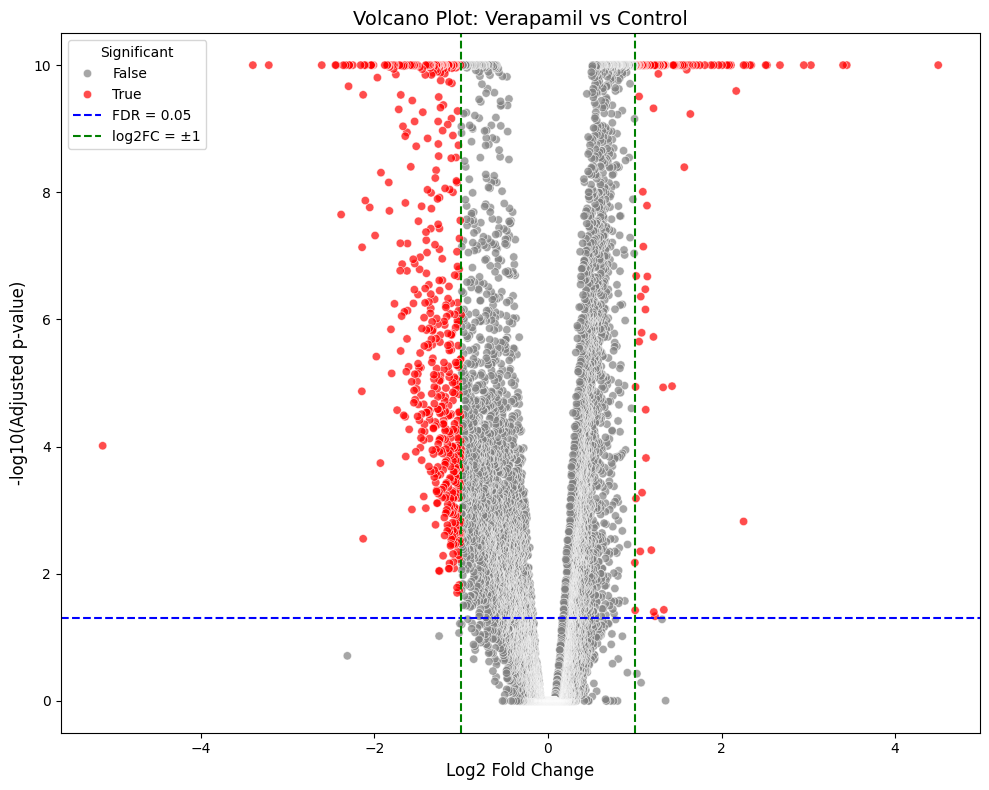

In [9]:
# Add significance column
df["significant"] = (df["Adj.Pvalue"] < 0.05) & (df["Log2_fold_change"].abs() > 1)

# Compute -log10 adjusted p-value
df["-log10(pval)"] = -np.log10(df["Adj.Pvalue"] + 1e-10)

# Plot
plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=df,
    x="Log2_fold_change",
    y="-log10(pval)",
    hue="significant",
    palette={True: "red", False: "gray"},
    alpha=0.7
)

# Threshold lines
plt.axhline(-np.log10(0.05), color="blue", linestyle="--", label="FDR = 0.05")
plt.axvline(1, color="green", linestyle="--", label="log2FC = ±1")
plt.axvline(-1, color="green", linestyle="--")

# Labels
plt.title("Volcano Plot: Verapamil vs Control", fontsize=14)
plt.xlabel("Log2 Fold Change", fontsize=12)
plt.ylabel("-log10(Adjusted p-value)", fontsize=12)
plt.legend(title="Significant")
plt.tight_layout()
plt.show()


In [10]:
!pip install adjustText


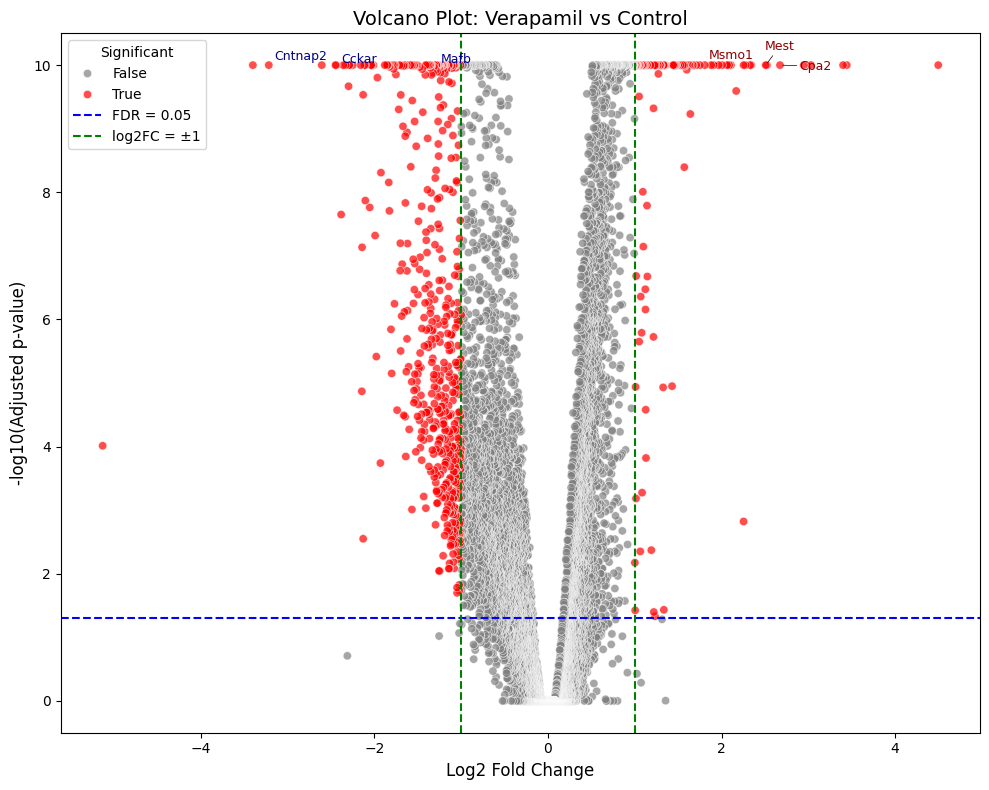

In [11]:
from adjustText import adjust_text

# Calculate significance and -log10(pval)
df["significant"] = (df["Adj.Pvalue"] < 0.05) & (df["Log2_fold_change"].abs() > 1)
df["-log10(pval)"] = -np.log10(df["Adj.Pvalue"] + 1e-10)

# Top up/down genes
sig_up = df[(df["significant"]) & (df["Log2_fold_change"] > 1)]
sig_down = df[(df["significant"]) & (df["Log2_fold_change"] < -1)]

top_up = sig_up.nsmallest(3, "Adj.Pvalue")
top_down = sig_down.nsmallest(3, "Adj.Pvalue")

# Start plot
plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=df,
    x="Log2_fold_change",
    y="-log10(pval)",
    hue="significant",
    palette={True: "red", False: "gray"},
    alpha=0.7
)

plt.axhline(-np.log10(0.05), color="blue", linestyle="--", label="FDR = 0.05")
plt.axvline(1, color="green", linestyle="--", label="log2FC = ±1")
plt.axvline(-1, color="green", linestyle="--")

# Auto-adjusting annotations
texts = []

for _, row in top_up.iterrows():
    texts.append(plt.text(row["Log2_fold_change"], row["-log10(pval)"], row["Gene_Symbol"],
                          fontsize=9, color='darkred'))

for _, row in top_down.iterrows():
    texts.append(plt.text(row["Log2_fold_change"], row["-log10(pval)"], row["Gene_Symbol"],
                          fontsize=9, color='darkblue'))

adjust_text(texts, arrowprops=dict(arrowstyle="-", color='black', lw=0.5))

# Finish plot
plt.title("Volcano Plot: Verapamil vs Control", fontsize=14)
plt.xlabel("Log2 Fold Change", fontsize=12)
plt.ylabel("-log10(Adjusted p-value)", fontsize=12)
plt.legend(title="Significant")
plt.tight_layout()
plt.show()


In [12]:
# Perform Gene Ontology Enrichment Analysis
go_results = gp.enrichr(
    gene_list=genes,
    gene_sets="GO_Biological_Process_2021",
    organism="Mouse",
    outdir=None
)
print("Top GO Biological Process enrichment results:")
go_results.results.head(10)

Top GO Biological Process enrichment results:


,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,GO_Biological_Process_2021,secondary alcohol biosynthetic process (GO:190...,12/34,5.139357e-10,0.000001,0,0,15.980411,341.803781,IDI1;FDPS;HMGCS1;INSIG1;MSMO1;DHCR24;MVD;HMGCR...
1,GO_Biological_Process_2021,cholesterol biosynthetic process (GO:0006695),12/35,7.583585e-10,0.000001,0,0,15.284819,320.979132,IDI1;FDPS;HMGCS1;INSIG1;MSMO1;DHCR24;MVD;HMGCR...
2,GO_Biological_Process_2021,sterol biosynthetic process (GO:0016126),12/38,2.243501e-09,0.000002,0,0,13.519085,269.235661,IDI1;FDPS;HMGCS1;INSIG1;MSMO1;DHCR24;MVD;HMGCR...
3,GO_Biological_Process_2021,regulation of cell cycle G2/M phase transition...,15/85,1.338993e-07,0.000094,0,0,6.291050,99.563271,OFD1;PLK4;HSP90AA1;ATAD5;KIF14;HAUS3;HAUS6;HMM...
4,GO_Biological_Process_2021,cholesterol metabolic process (GO:0008203),14/77,2.381368e-07,0.000134,0,0,6.516489,99.379198,ABCA1;IDI1;FDPS;HMGCS1;INSIG1;MSMO1;DHCR24;HMG...
5,GO_Biological_Process_2021,ciliary basal body-plasma membrane docking (GO...,14/95,3.322644e-06,0.001556,0,0,5.063645,63.876615,OFD1;PLK4;HSP90AA1;SCLT1;HAUS3;KIF24;HAUS6;RPG...
6,GO_Biological_Process_2021,mitotic spindle organization (GO:0007052),18/157,5.685533e-06,0.002282,0,0,3.805568,45.962075,OFD1;RANBP2;ERCC6L;KIF23;TTK;KNL1;KIF11;SMC3;N...
7,GO_Biological_Process_2021,positive regulation of filopodium assembly (GO...,7/26,1.747348e-05,0.006135,0,0,10.714172,117.371899,GPM6A;NRP1;TENM1;DOCK11;FMR1;DPYSL3;FNBP1L
8,GO_Biological_Process_2021,cilium assembly (GO:0060271),26/314,2.333595e-05,0.007283,0,0,2.665084,28.424494,FNBP1L;RPGR;IFT74;PCM1;ARL13B;CNTRL;NEK1;CEP19...
9,GO_Biological_Process_2021,positive regulation of cell cycle process (GO:...,13/101,3.289618e-05,0.008559,0,0,4.319788,44.589516,PLK4;CEP295;ATRX;KIF14;KIF23;NDC80;CSPP1;TPR;N...


Top KEGG pathway enrichment results:


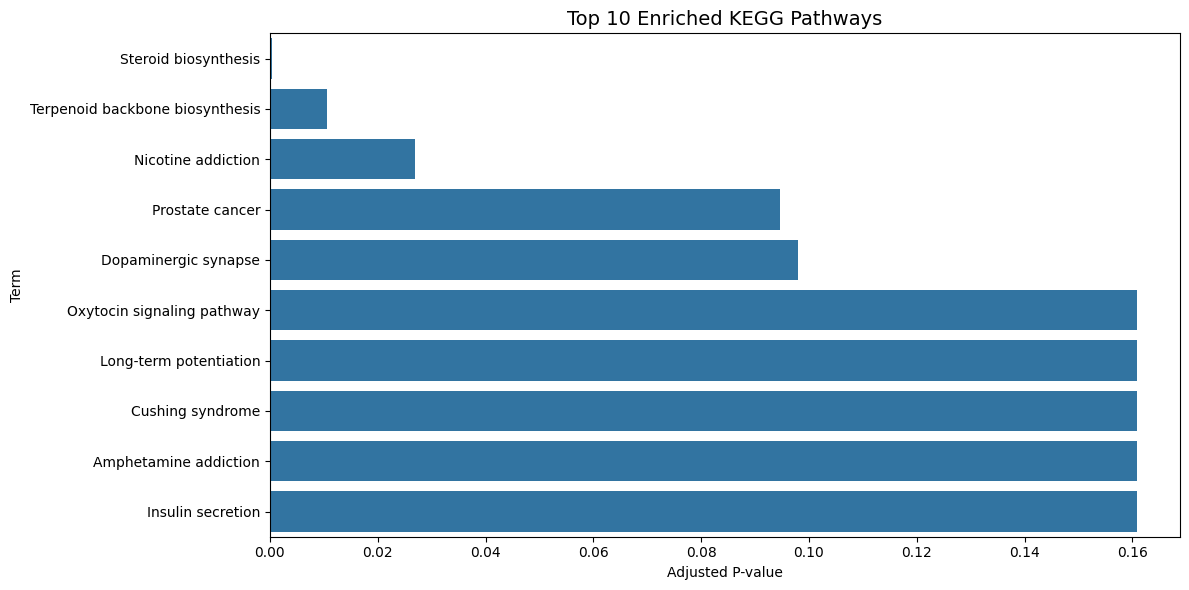

In [13]:
# KEGG Pathway Analysis
kegg_results = gp.enrichr(
    gene_list=genes,
    gene_sets="KEGG_2019_Mouse",
    organism="Mouse",
    outdir=None
)
print("Top KEGG pathway enrichment results:")
kegg_results.results.head(10)

# Plot top enriched pathways
plt.figure(figsize=(12, 6))
kegg_df = kegg_results.results.sort_values('Adjusted P-value').head(10)
sns.barplot(x='Adjusted P-value', y='Term', data=kegg_df)
plt.title('Top 10 Enriched KEGG Pathways', fontsize=14)
plt.tight_layout()
plt.show()

In [14]:
# Comprehensive Gene Ontology and Pathway Enrichment Analysis

# Define the gene list from your DEGs
gene_list = deg["Gene_Symbol"].dropna().astype(str).tolist()
print(f"Performing enrichment analysis for {len(gene_list)} differentially expressed genes...")

# Set organism
organism = 'Mouse'

# Create a list of databases to query
databases = [
    # Gene Ontology categories
    'GO_Biological_Process_2021',
    'GO_Molecular_Function_2021',
    'GO_Cellular_Component_2021',
    # Pathways
    'KEGG_2019_Mouse',
    'WikiPathways_2019_Mouse',
    'Reactome_2022',
    # Other categories
    'TRANSFAC_and_JASPAR_PWMs',  # Transcription factor binding sites
    'Transcription_Factor_PPIs',  # Transcription factor interactions
    'PPI_Hub_Proteins'  # Protein interaction hubs
]

# Dictionary to store results
enrichment_results = {}

Performing enrichment analysis for 671 differentially expressed genes...


In [15]:
# Function to plot enrichment results
def plot_enrichment(results_df, title, top_n=10):
    """Plot top enriched terms"""
    # Sort by adjusted p-value and take top N
    plot_df = results_df.sort_values('Adjusted P-value').head(top_n).copy()

    # Add count information to term names
    plot_df['Term_with_count'] = plot_df['Term'] + ' (' + plot_df['Overlap'].astype(str) + ')'

    # Add -log10(p-value) for plotting
    plot_df['log10_pval'] = -np.log10(plot_df['Adjusted P-value'])

    # Create the plot
    plt.figure(figsize=(10, max(6, 0.3 * len(plot_df))))

    # Create barplot
    sns.barplot(
        data=plot_df,
        x='log10_pval',
        y='Term_with_count',
        palette='viridis',
        orient='h'
    )

    # Add vertical line for significance threshold (p=0.05)
    plt.axvline(-np.log10(0.05), color='red', linestyle='--', label='p=0.05')

    plt.title(title)
    plt.xlabel('-log10(Adjusted P-value)')
    plt.tight_layout()

    # Save figure
    filename = title.replace(' ', '_').replace('/', '_').lower() + '.png'
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()


Analyzing GO_Biological_Process_2021...
  Found 26 significant terms in GO_Biological_Process_2021


<ipython-input-15-38e58d617de9>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


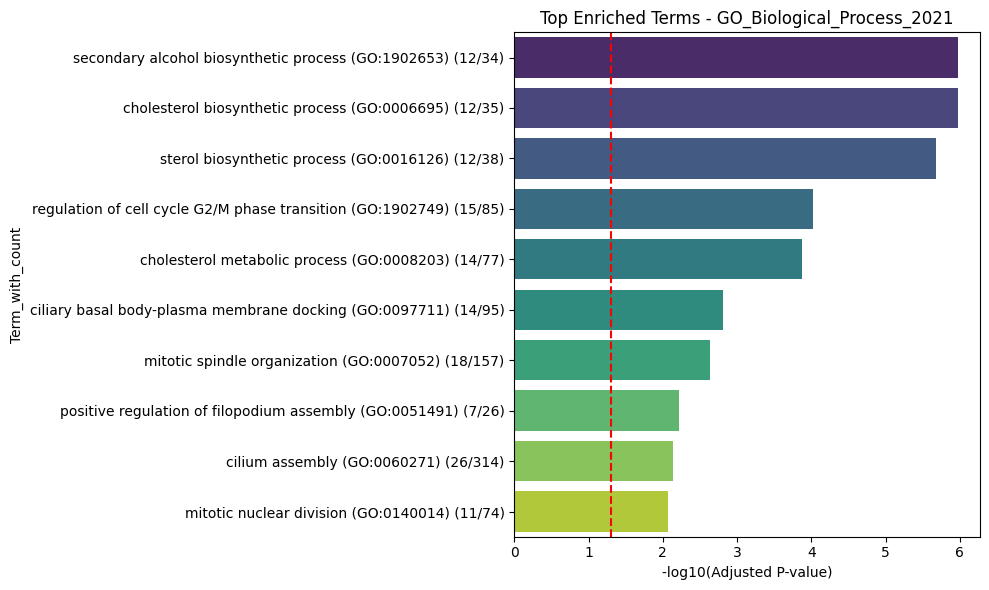

Analyzing GO_Molecular_Function_2021...
  Found 21 significant terms in GO_Molecular_Function_2021


<ipython-input-15-38e58d617de9>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


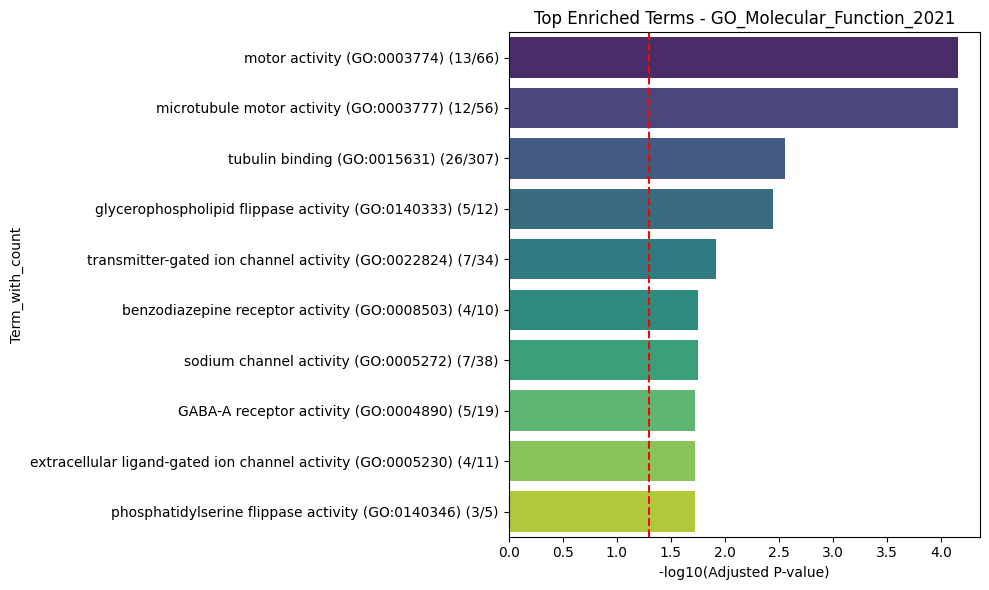

Analyzing GO_Cellular_Component_2021...
  Found 11 significant terms in GO_Cellular_Component_2021


<ipython-input-15-38e58d617de9>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


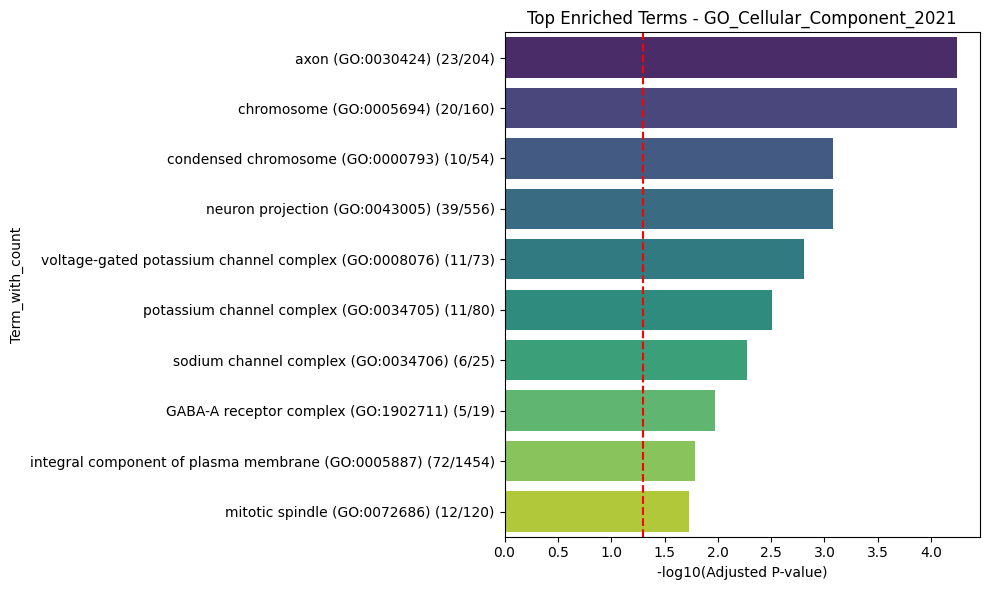

Analyzing KEGG_2019_Mouse...
  Found 3 significant terms in KEGG_2019_Mouse


<ipython-input-15-38e58d617de9>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


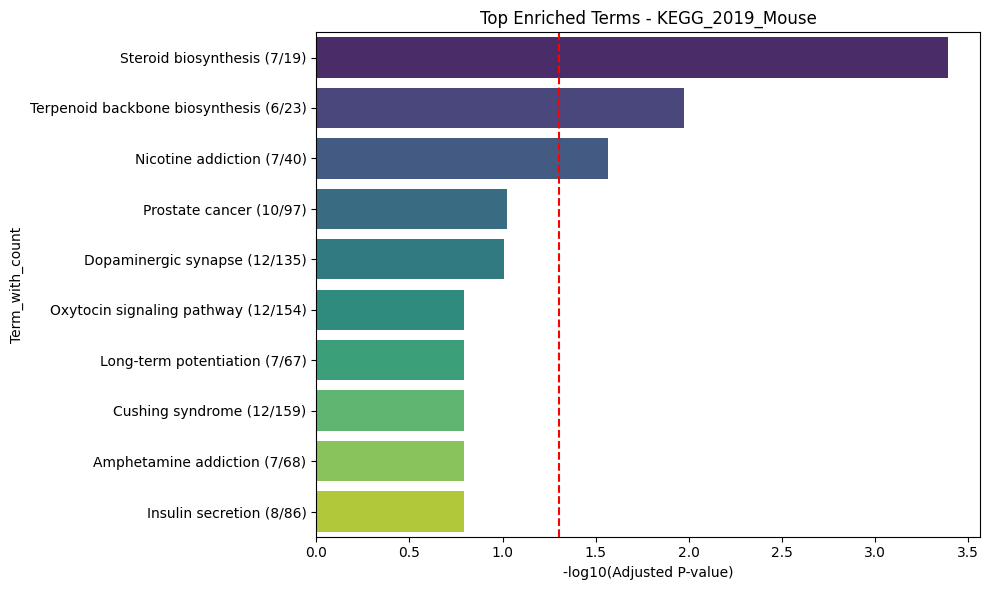

Analyzing WikiPathways_2019_Mouse...
  Found 2 significant terms in WikiPathways_2019_Mouse


<ipython-input-15-38e58d617de9>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


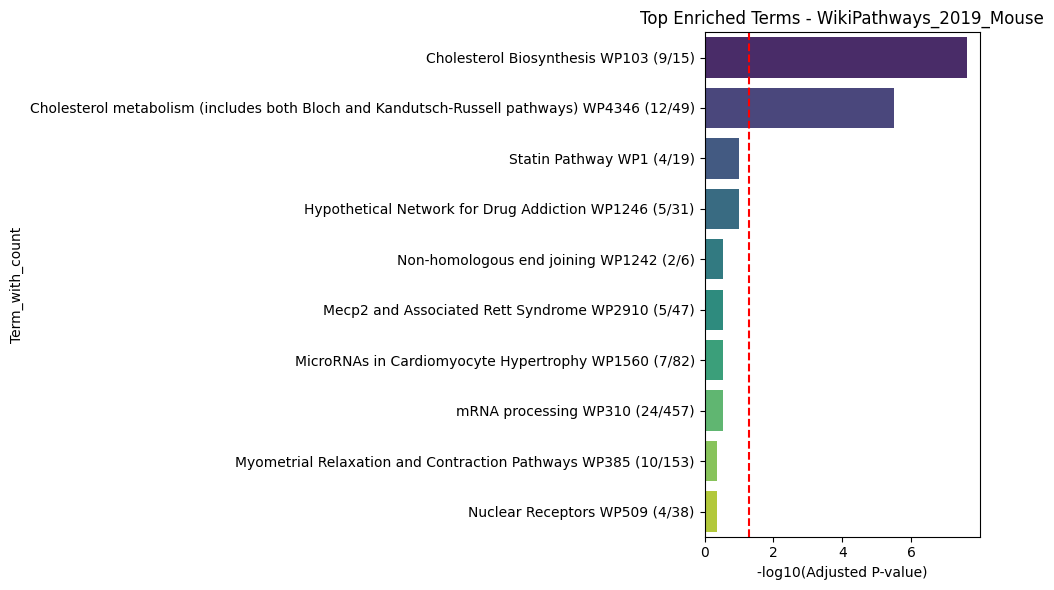

Analyzing Reactome_2022...
  Found 33 significant terms in Reactome_2022


<ipython-input-15-38e58d617de9>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


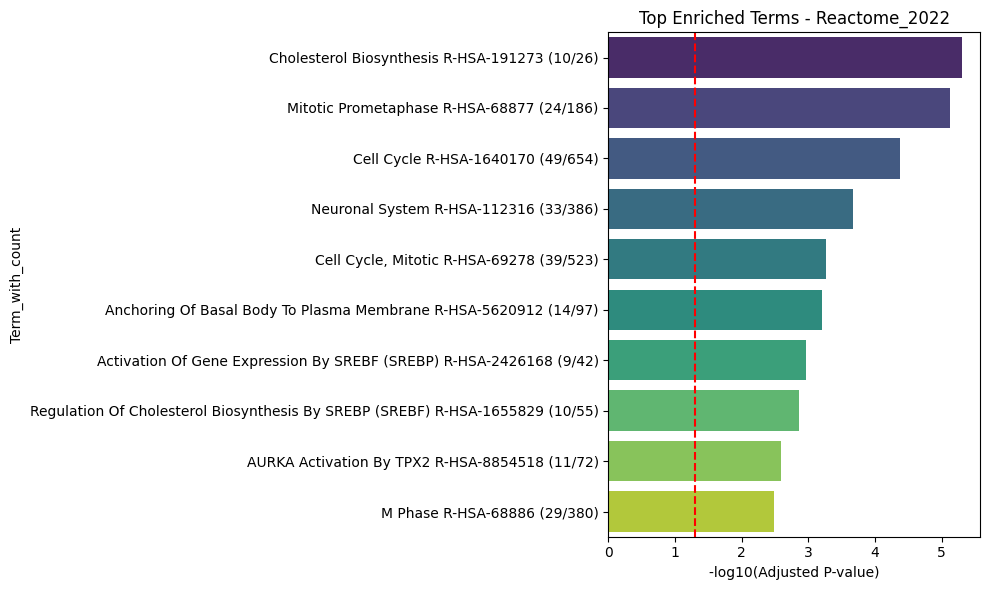

Analyzing TRANSFAC_and_JASPAR_PWMs...
  No significant terms found in TRANSFAC_and_JASPAR_PWMs
Analyzing Transcription_Factor_PPIs...
  Found 2 significant terms in Transcription_Factor_PPIs


<ipython-input-15-38e58d617de9>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


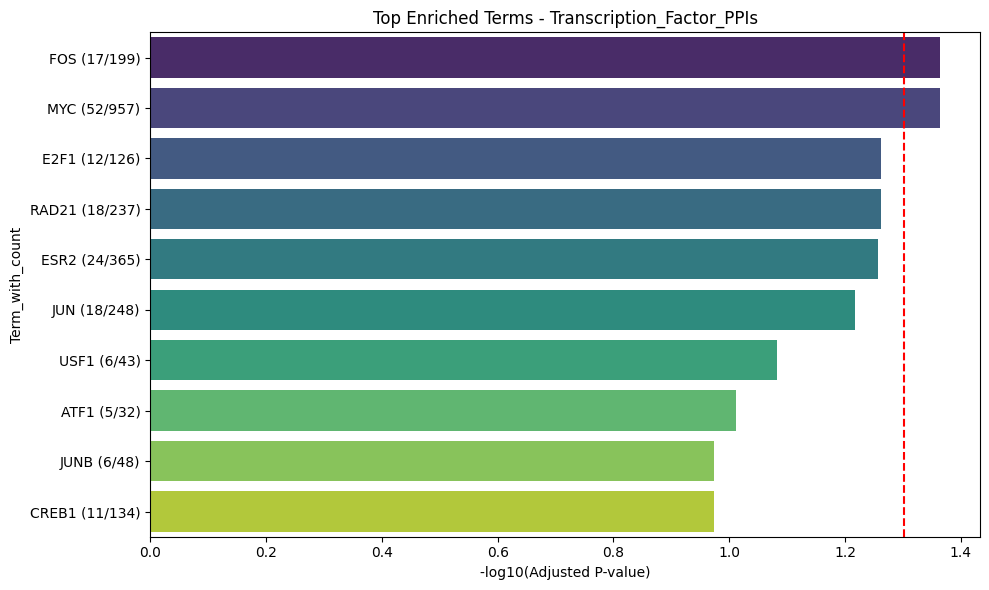

Analyzing PPI_Hub_Proteins...
  Found 3 significant terms in PPI_Hub_Proteins


<ipython-input-15-38e58d617de9>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


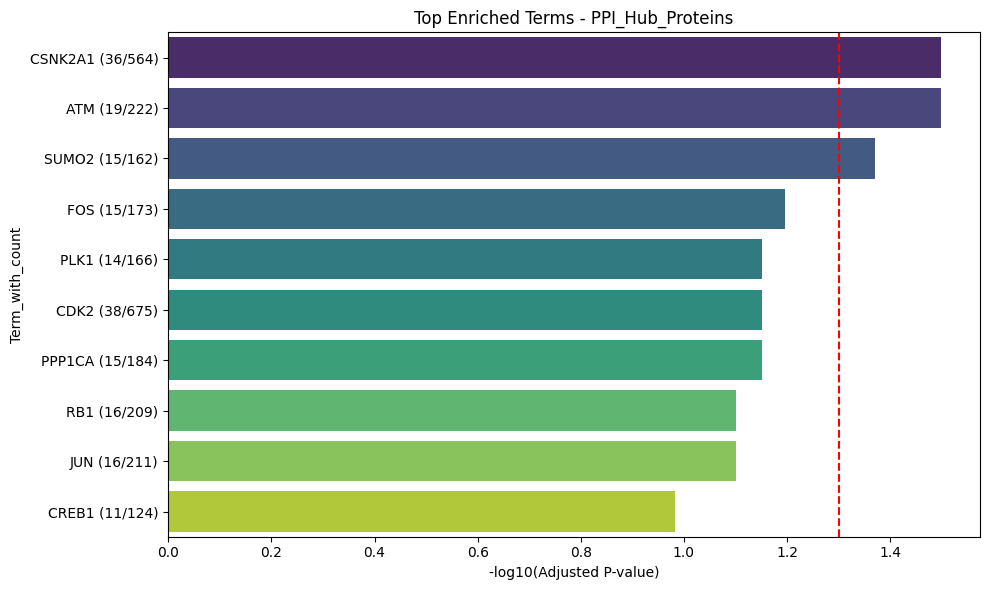

In [16]:
# Perform enrichment analysis for each database
for database in databases:
    print(f"Analyzing {database}...")
    try:
        # Run enrichr
        enrichment = gp.enrichr(
            gene_list=gene_list,
            gene_sets=[database],
            organism=organism,
            outdir=None
        )

        # Store results
        results_df = enrichment.results

        # Filter for significant results (adjusted p-value < 0.05)
        significant_results = results_df[results_df['Adjusted P-value'] < 0.05]

        # Store in dictionary
        enrichment_results[database] = significant_results

        # Print summary
        if len(significant_results) > 0:
            print(f"  Found {len(significant_results)} significant terms in {database}")
            # Plot the top results
            plot_title = f"Top Enriched Terms - {database}"
            plot_enrichment(results_df, plot_title)
        else:
            print(f"  No significant terms found in {database}")

    except Exception as e:
        print(f"  Error analyzing {database}: {e}")



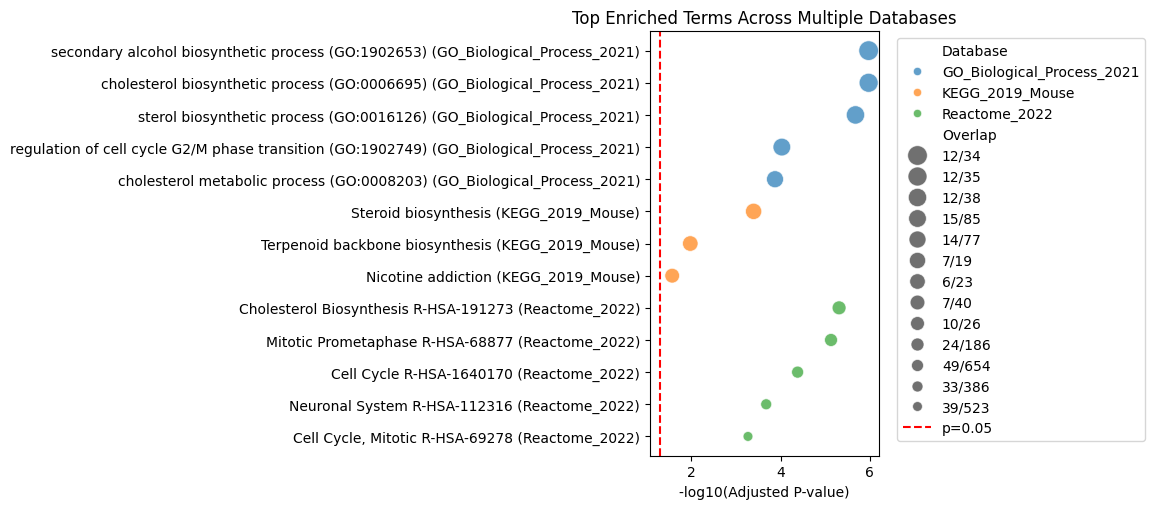

In [17]:
# Combined visualization of top pathways across multiple databases
# Select GO BP, KEGG, and Reactome for combined visualization
selected_dbs = ['GO_Biological_Process_2021', 'KEGG_2019_Mouse', 'Reactome_2022']
combined_results = []

for db in selected_dbs:
    if db in enrichment_results and not enrichment_results[db].empty:
        # Get top 5 from each database
        temp_df = enrichment_results[db].sort_values('Adjusted P-value').head(5).copy()
        temp_df['Database'] = db
        combined_results.append(temp_df)

if combined_results:
    # Combine results
    combined_df = pd.concat(combined_results, ignore_index=True)

    # Create formatted term labels
    combined_df['Label'] = combined_df['Term'] + ' (' + combined_df['Database'] + ')'

    # Create the plot
    plt.figure(figsize=(12, 0.4 * len(combined_df)))

    # Plot
    scatter = sns.scatterplot(
        data=combined_df,
        y='Label',
        x=-np.log10(combined_df['Adjusted P-value']),
        size='Overlap',  # Size points by number of genes
        hue='Database',  # Color by database
        sizes=(50, 200),
        alpha=0.7
    )

    # Add vertical line for significance threshold
    plt.axvline(-np.log10(0.05), color='red', linestyle='--', label='p=0.05')

    plt.title('Top Enriched Terms Across Multiple Databases')
    plt.xlabel('-log10(Adjusted P-value)')
    plt.ylabel('')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.savefig('combined_enrichment.png', dpi=300, bbox_inches='tight')
    plt.show()



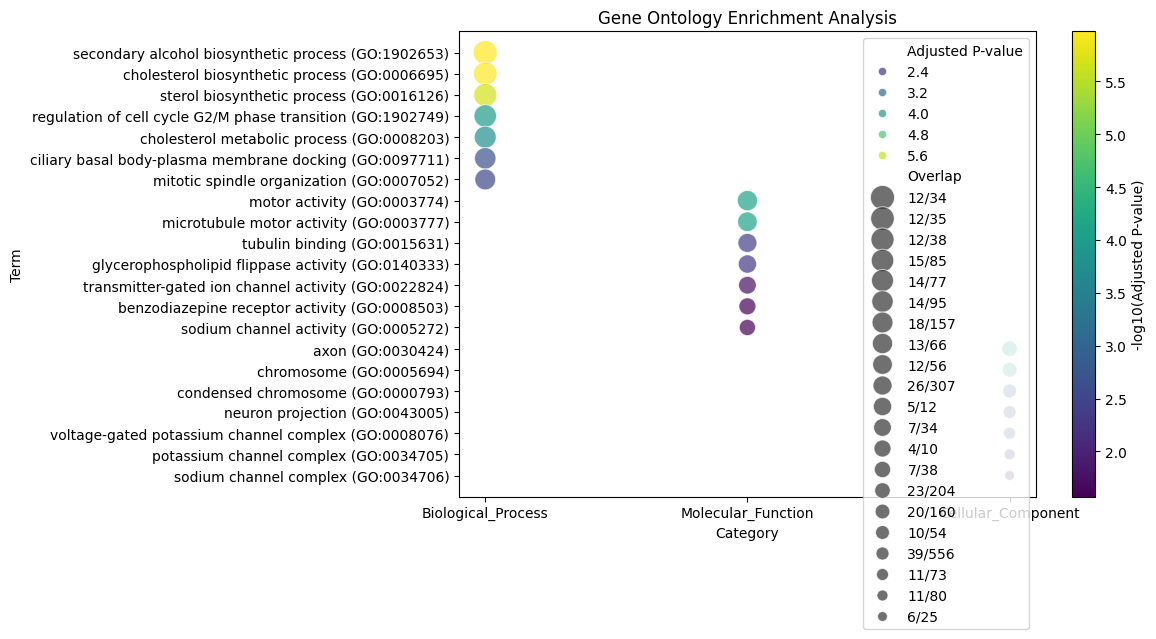

In [19]:
# Create dotplot visualization for top GO terms
try:
    # Select only GO terms
    go_dbs = [db for db in enrichment_results.keys() if db.startswith('GO_')]
    go_results = []
    for db in go_dbs:
        if not enrichment_results[db].empty:
            # Get top terms
            temp_df = enrichment_results[db].sort_values('Adjusted P-value').head(7).copy()
            temp_df['Category'] = db.replace('GO_', '').replace('_2021', '')
            go_results.append(temp_df)
    if go_results:
        go_combined = pd.concat(go_results, ignore_index=True)
        # Calculate enrichment ratio
        go_combined['Gene_Ratio'] = go_combined['Overlap'].apply(
            lambda x: float(x.split('/')[0]) / float(x.split('/')[1])
        )
        # Create dot plot
        fig, ax = plt.subplots(figsize=(12, max(6, 0.3 * len(go_combined))))
        # Create a scatter plot with point size based on gene count
        scatter = sns.scatterplot(
            data=go_combined,
            y='Term',
            x='Category',
            size='Overlap',  # Size of points based on gene count
            hue=-np.log10(go_combined['Adjusted P-value']),  # Color based on p-value
            palette='viridis',
            sizes=(50, 300),
            alpha=0.7,
            ax=ax  # Explicitly provide the axis
        )
        # Add a colorbar
        norm = plt.Normalize(
            -np.log10(go_combined['Adjusted P-value']).min(),
            -np.log10(go_combined['Adjusted P-value']).max()
        )
        sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
        sm.set_array([])
        cbar = plt.colorbar(sm, ax=ax)  # Explicitly provide the axis
        cbar.set_label('-log10(Adjusted P-value)')
        plt.title('Gene Ontology Enrichment Analysis')
        plt.tight_layout()
        plt.savefig('go_dotplot.png', dpi=300, bbox_inches='tight')
        plt.show()
except Exception as e:
    print(f"Error creating GO dotplot: {e}")

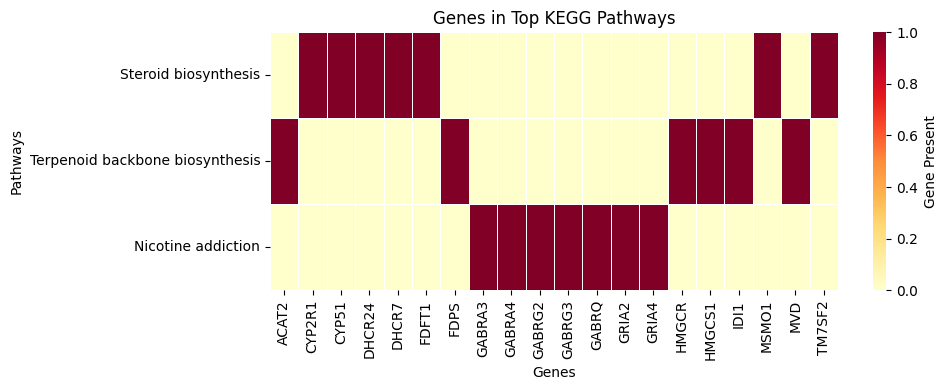

In [20]:
# Create interactive heatmap of top pathway genes
try:
    if 'KEGG_2019_Mouse' in enrichment_results and not enrichment_results['KEGG_2019_Mouse'].empty:
        # Get top KEGG pathways
        top_pathways = enrichment_results['KEGG_2019_Mouse'].sort_values('Adjusted P-value').head(5)

        # Get genes in each pathway
        pathway_genes = {}
        for _, row in top_pathways.iterrows():
            genes = row['Genes'].split(';')
            pathway_genes[row['Term']] = genes

        # Find all unique genes and sort alphabetically for consistent ordering
        all_genes = sorted(set(g for genes in pathway_genes.values() for g in genes))

        # Create a binary matrix (pathways x genes)
        matrix_data = []
        for pathway, genes in pathway_genes.items():
            row_data = [1 if gene in genes else 0 for gene in all_genes]
            matrix_data.append(row_data)

        # Create DataFrame
        pathway_matrix = pd.DataFrame(matrix_data, index=pathway_genes.keys(), columns=all_genes)

        # Set figure size dynamically
        fig_width = max(10, 0.4 * len(all_genes))
        fig_height = max(4, 0.6 * len(pathway_genes))

        # Plot heatmap
        plt.figure(figsize=(fig_width, fig_height))
        sns.heatmap(
            pathway_matrix,
            cmap='YlOrRd',
            cbar_kws={'label': 'Gene Present'},
            linewidths=0.5
        )
        plt.title('Genes in Top KEGG Pathways')
        plt.xlabel('Genes')
        plt.ylabel('Pathways')

        # Rotate x-axis labels for better readability
        plt.xticks(rotation=90)
        plt.yticks(rotation=0)

        plt.tight_layout()
        plt.savefig('pathway_gene_heatmap.png', dpi=300, bbox_inches='tight')
        plt.show()
except Exception as e:
    print(f"Error creating pathway gene heatmap: {e}")



In [21]:
# Save all enrichment results to Excel with multiple sheets
print("\nSaving all enrichment results to 'enrichment_analysis_results.xlsx'...")
with pd.ExcelWriter('enrichment_analysis_results.xlsx') as writer:
    for db, results in enrichment_results.items():
        if not results.empty:
            # Clean sheet name (remove special characters not allowed in Excel sheet names)
            sheet_name = db.replace('/', '_').replace('[', '').replace(']', '')
            # Truncate if necessary (Excel has a 31 character limit for sheet names)
            sheet_name = sheet_name[:31]
            # Save to sheet
            results.to_excel(writer, sheet_name=sheet_name, index=False)

print("Enrichment analysis complete! Results saved to Excel file and visualizations saved as PNG images.")


Saving all enrichment results to 'enrichment_analysis_results.xlsx'...
Enrichment analysis complete! Results saved to Excel file and visualizations saved as PNG images.


In [22]:
# PPI Network Analysis for DEGs
from io import StringIO
# Extract gene list (use Gene_Symbol column from your DEGs)
gene_list = deg["Gene_Symbol"].dropna().unique().tolist()
print(f"Analyzing PPI network for {len(gene_list)} differentially expressed genes...")



Analyzing PPI network for 671 differentially expressed genes...


In [23]:
# Function to fetch PPI data from STRING
def fetch_string_ppi(gene_list, species='10090', score_threshold=0.7):  # 10090 is mouse
    """
    Fetch protein-protein interaction data from STRING database
    Args:
        gene_list: List of gene symbols
        species: Species taxon ID (10090 for mouse, 9606 for human)
        score_threshold: Minimum confidence score for interactions
    Returns:
        DataFrame with PPI data
    """
    base_url = "https://string-db.org/api/tsv/network"
    # Only take first 2000 genes if list is too long (STRING API limitation)
    if len(gene_list) > 2000:
        print(f"Warning: Limiting to first 2000 genes out of {len(gene_list)}")
        gene_list = gene_list[:2000]

    genes = "\r".join(gene_list)  # STRING API expects \r separator

    params = {
        'identifiers': genes,
        'species': species,
        'networkType': 'functional',
        'caller_identity': 'www.your_app.org'
    }

    try:
        response = requests.post(base_url, data=params)
        if response.status_code == 200:
            # Parse the response to a DataFrame
            ppi_df = pd.read_csv(StringIO(response.text), sep="\t")

            # Filter by confidence score
            if 'score' in ppi_df.columns:
                ppi_df_filtered = ppi_df[ppi_df['score'] > score_threshold]
                print(f"Retrieved {len(ppi_df)} interactions, {len(ppi_df_filtered)} after filtering (score > {score_threshold})")
                return ppi_df_filtered
            else:
                print("Warning: No 'score' column found in response")
                return ppi_df
        else:
            print(f"Failed to fetch data from STRING: {response.status_code}")
            print(f"Response content: {response.text[:200]}...")
            return None
    except Exception as e:
        print(f"Error fetching PPI data: {e}")
        return None



Retrieved 2655 interactions, 793 after filtering (score > 0.7)
Building PPI network...
PPI Network Stats:
- Number of nodes: 297
- Number of edges: 793
- Network density: 0.018041
- Number of connected components: 22
- Size of largest component: 225 nodes


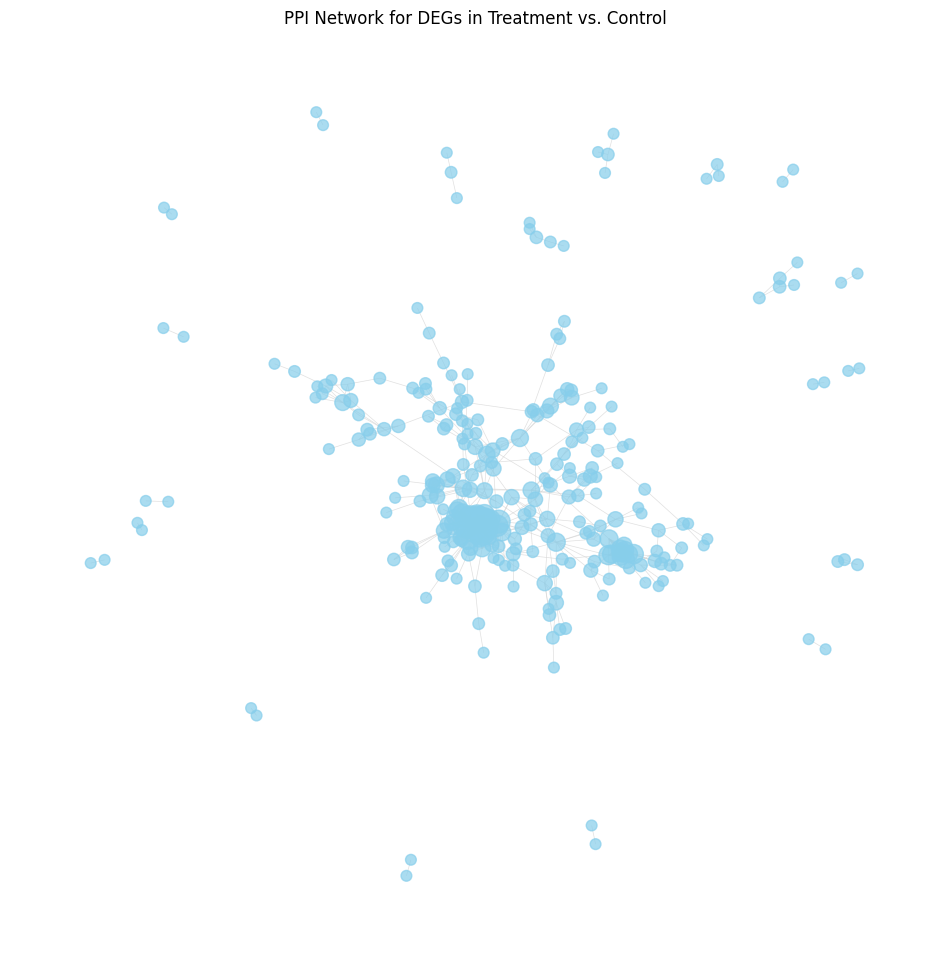

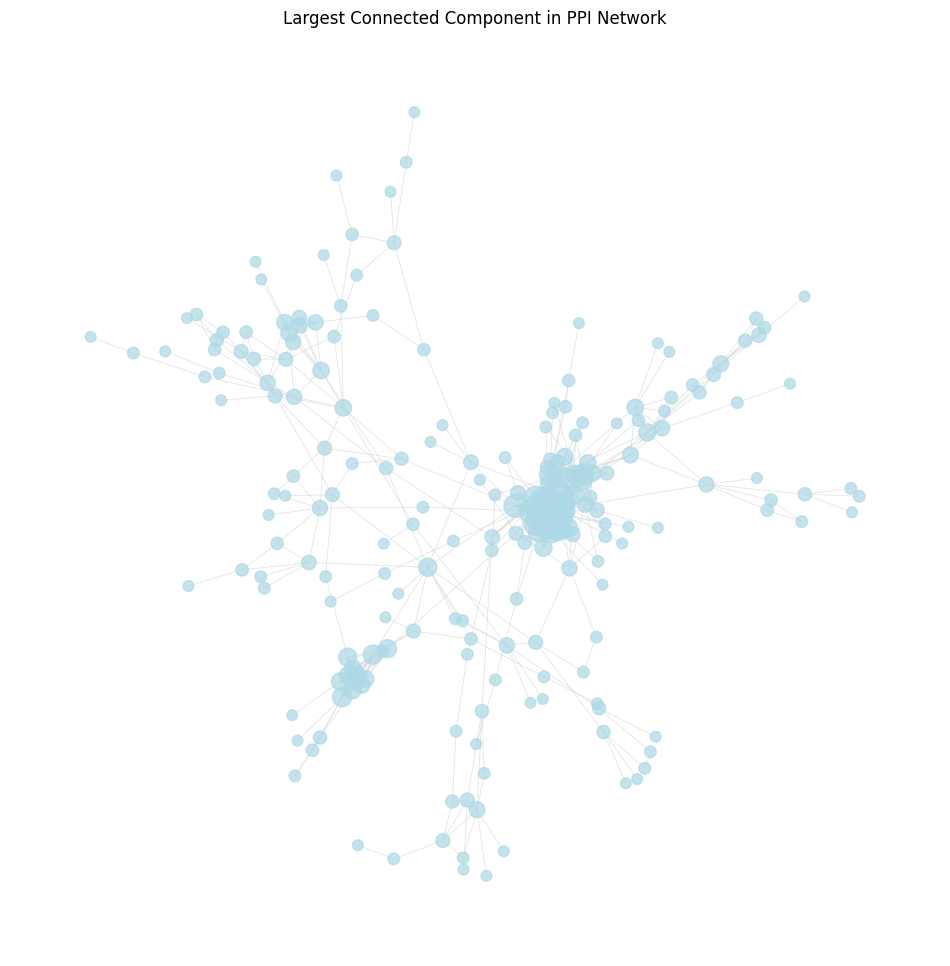


Calculating network centrality measures...

Top 10 nodes by degree centrality:
1. Kif11: 0.1115
2. Bub1: 0.1047
3. Smc2: 0.1014
4. Cenpe: 0.1014
5. Ncapg: 0.0980
6. Top2a: 0.0946
7. Nuf2: 0.0946
8. Nusap1: 0.0946
9. Ttk: 0.0946
10. Cenpf: 0.0878

Top 10 nodes by betweenness centrality:
1. Ins2: 0.1726
2. Mki67: 0.1707
3. Ranbp2: 0.1070
4. Kif5b: 0.0822
5. Camk2a: 0.0678
6. Brca1: 0.0590
7. Prpf40a: 0.0583
8. Hmgcr: 0.0580
9. Rpgr: 0.0546
10. Pbrm1: 0.0488

Top 10 nodes with highest clustering coefficients:
1. Scnn1g: 1.0000
2. Scn3a: 1.0000
3. Insig1: 1.0000
4. Klf5: 1.0000
5. Cebpd: 1.0000
6. Acss2: 1.0000
7. Mastl: 1.0000
8. Polq: 1.0000
9. Rad50: 1.0000
10. Ak4: 1.0000


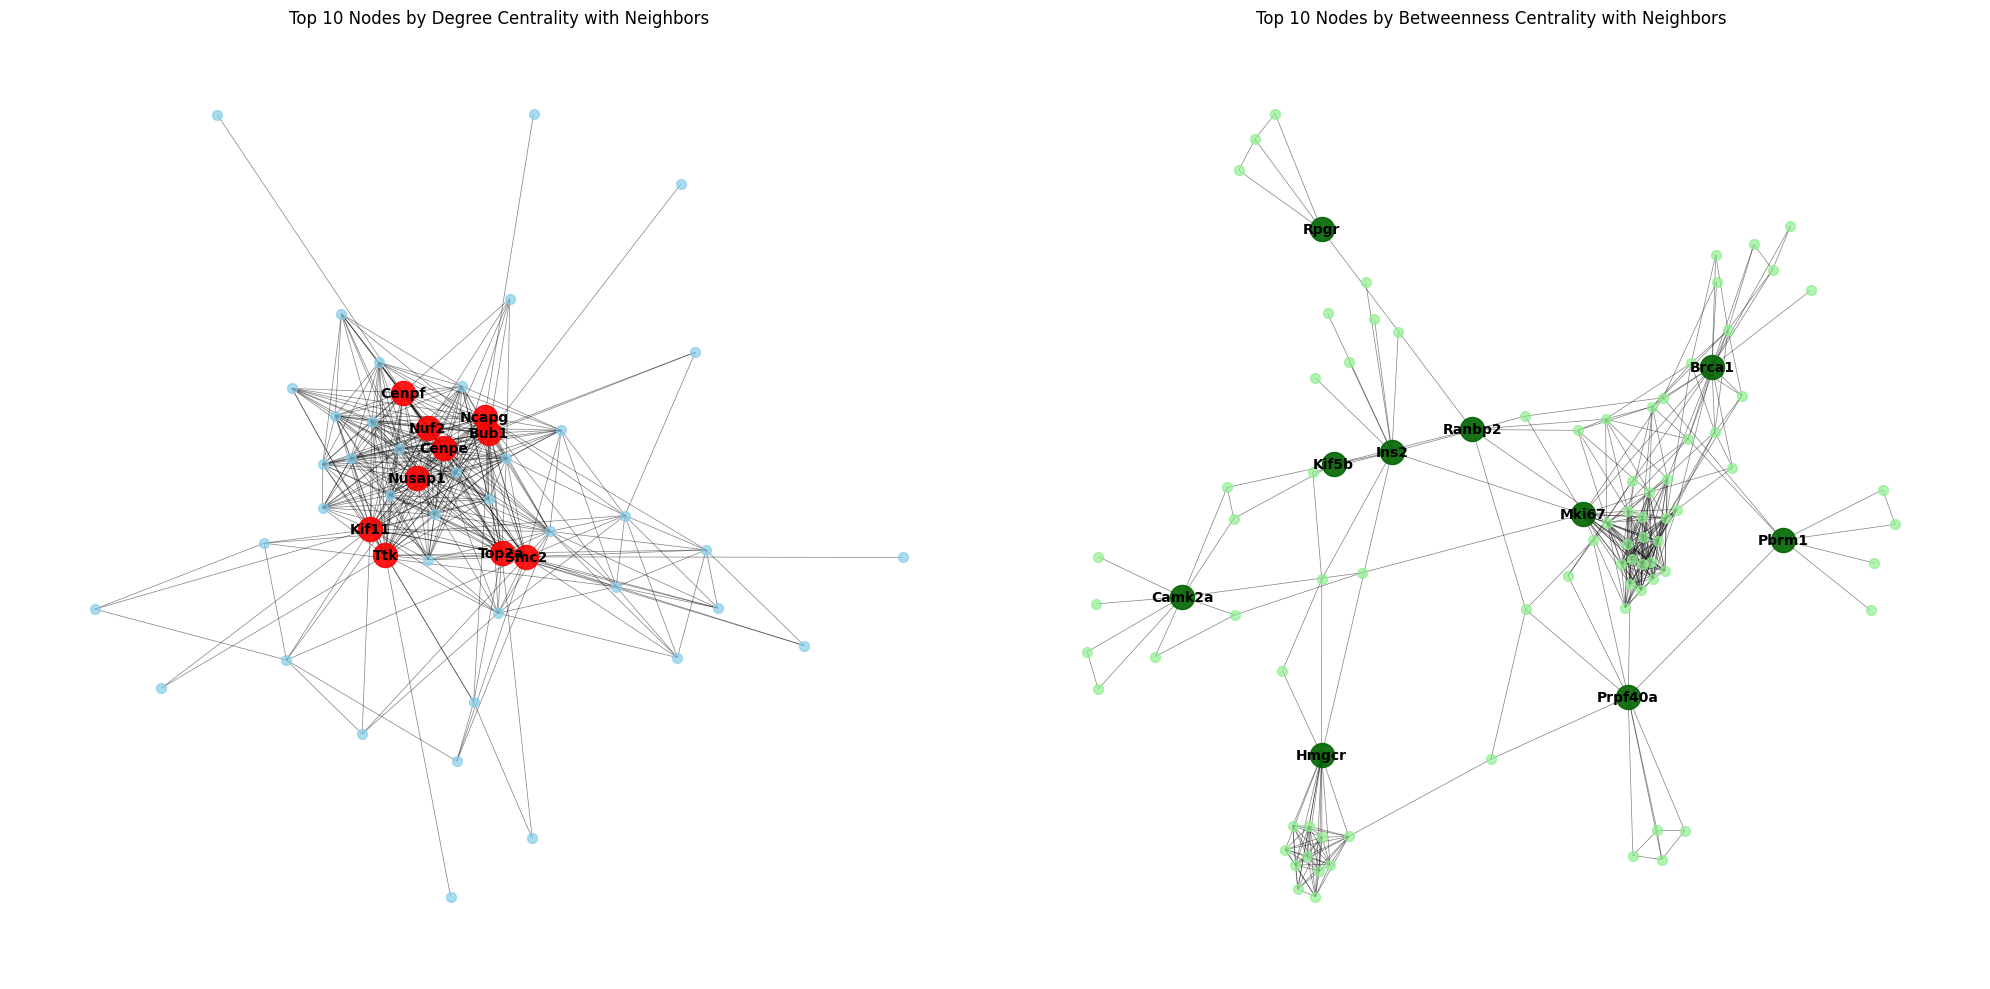


Centrality measures saved to 'ppi_network_centrality_measures.csv'

Detecting functional modules in the network...
Found 31 functional modules
Top 5 module sizes: [64, 32, 32, 24, 24]


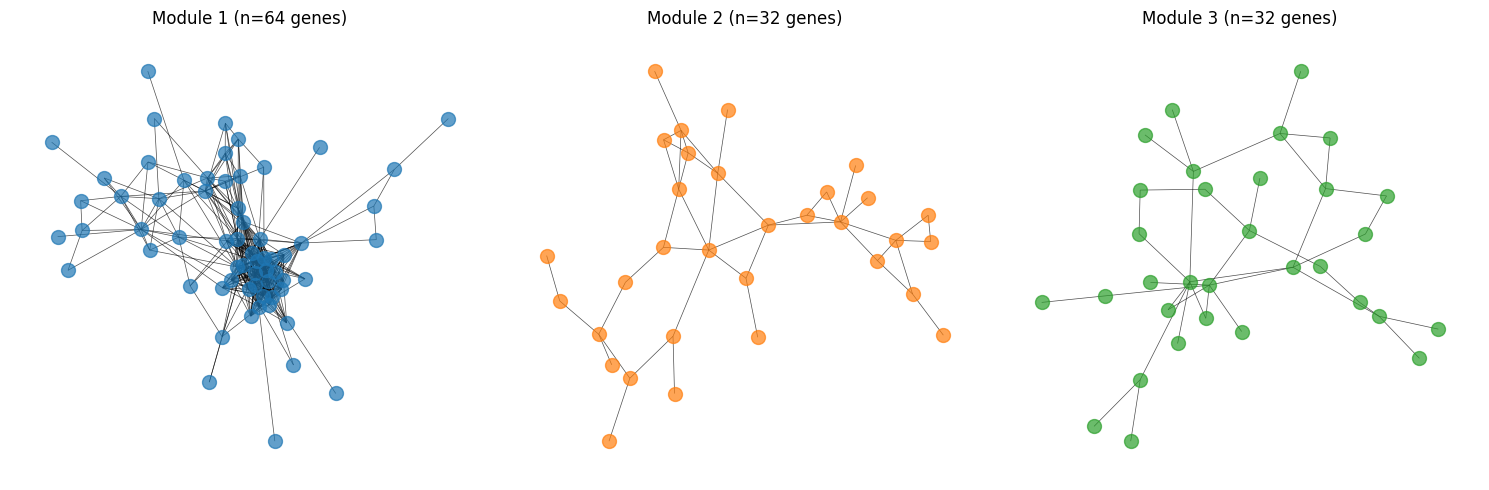

In [24]:
# Fetch PPI network data with appropriate species parameter

ppi_df = fetch_string_ppi(gene_list, species='10090', score_threshold=0.7)

# If no data was retrieved, provide a message and continue with rest of analysis
if ppi_df is None or len(ppi_df) == 0:
    print("No PPI data retrieved. Check your input gene list or try a different species parameter.")
    # Create a placeholder empty graph
    G = nx.Graph()
else:
    # Create the PPI network
    print("Building PPI network...")
    G = nx.Graph()

    # Add edges with weights
    for _, row in ppi_df.iterrows():
        G.add_edge(row['preferredName_A'], row['preferredName_B'], weight=row['score'])

    # Print network statistics
    print(f"PPI Network Stats:")
    print(f"- Number of nodes: {G.number_of_nodes()}")
    print(f"- Number of edges: {G.number_of_edges()}")
    print(f"- Network density: {nx.density(G):.6f}")

    # Find connected components
    components = list(nx.connected_components(G))
    print(f"- Number of connected components: {len(components)}")
    print(f"- Size of largest component: {len(max(components, key=len))} nodes")

    # Visualize the entire network if not too large
    if G.number_of_nodes() <= 500:
        plt.figure(figsize=(12, 12))
        # Use spring layout with fixed seed for reproducibility
        pos = nx.spring_layout(G, seed=42)

        # Draw nodes with size based on degree
        node_degrees = dict(G.degree())
        node_sizes = [50 + 10 * node_degrees[node] for node in G.nodes()]

        nx.draw_networkx(
            G,
            pos=pos,
            node_size=node_sizes,
            with_labels=False,
            font_size=10,
            width=0.5,
            alpha=0.7,
            edge_color='lightgray',
            node_color='skyblue'
        )
        plt.title('PPI Network for DEGs in Treatment vs. Control')
        plt.axis('off')
        plt.savefig("full_ppi_network.png", dpi=300, bbox_inches='tight')
        plt.show()
    else:
        print(f"Network too large to visualize in full ({G.number_of_nodes()} nodes). Showing largest component.")

    # Get the largest connected component
    largest_component = max(components, key=len)
    subgraph = G.subgraph(largest_component).copy()

    # Visualize the largest component
    plt.figure(figsize=(12, 12))
    pos_sub = nx.spring_layout(subgraph, seed=42)

    # Calculate node sizes based on degree centrality
    node_degrees = dict(subgraph.degree())
    node_sizes = [50 + 10 * node_degrees[node] for node in subgraph.nodes()]

    nx.draw_networkx(
        subgraph,
        pos=pos_sub,
        node_size=node_sizes,
        with_labels=False,
        width=0.5,
        alpha=0.7,
        edge_color='lightgray',
        node_color='lightblue'
    )
    plt.title("Largest Connected Component in PPI Network")
    plt.axis('off')
    plt.savefig("largest_component_ppi.png", dpi=300, bbox_inches='tight')
    plt.show()

    # Calculate centrality measures
    print("\nCalculating network centrality measures...")

    # Degree centrality
    degree_centrality = nx.degree_centrality(G)
    top_degree_nodes = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:10]

    # Betweenness centrality (can be slow for large networks)
    if G.number_of_nodes() <= 1000:  # Only compute for reasonably sized networks
        betweenness_centrality = nx.betweenness_centrality(G)
        top_betweenness_nodes = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
    else:
        print("Network too large for betweenness centrality calculation. Using degree centrality only.")
        betweenness_centrality = {}
        top_betweenness_nodes = []

    # Clustering coefficients
    clustering_coefficients = nx.clustering(G)
    top_clustering_nodes = sorted(clustering_coefficients.items(), key=lambda x: x[1], reverse=True)[:10]

    # Print centrality results
    print("\nTop 10 nodes by degree centrality:")
    for i, (node, centrality) in enumerate(top_degree_nodes, 1):
        print(f"{i}. {node}: {centrality:.4f}")

    if top_betweenness_nodes:
        print("\nTop 10 nodes by betweenness centrality:")
        for i, (node, centrality) in enumerate(top_betweenness_nodes, 1):
            print(f"{i}. {node}: {centrality:.4f}")

    print("\nTop 10 nodes with highest clustering coefficients:")
    for i, (node, coeff) in enumerate(top_clustering_nodes, 1):
        print(f"{i}. {node}: {coeff:.4f}")

    # Create subgraphs for visualization
    # For degree centrality
    top_degree_nodes_list = [node for node, _ in top_degree_nodes]
    # Add neighbors of top nodes to get more context
    expanded_degree_nodes = set(top_degree_nodes_list)
    for node in top_degree_nodes_list:
        expanded_degree_nodes.update(G.neighbors(node))
    subgraph_degree = G.subgraph(expanded_degree_nodes).copy()

    # For betweenness centrality (if calculated)
    if top_betweenness_nodes:
        top_betweenness_nodes_list = [node for node, _ in top_betweenness_nodes]
        # Add neighbors
        expanded_betweenness_nodes = set(top_betweenness_nodes_list)
        for node in top_betweenness_nodes_list:
            expanded_betweenness_nodes.update(G.neighbors(node))
        subgraph_betweenness = G.subgraph(expanded_betweenness_nodes).copy()

    # Visualize both subgraphs side by side
    fig, axes = plt.subplots(1, 2 if top_betweenness_nodes else 1, figsize=(20, 10))

    # Function to draw subgraph with highlighted central nodes
    def draw_centrality_subgraph(G, central_nodes, ax, title, node_color='skyblue', highlight_color='red'):
        pos = nx.spring_layout(G, seed=42)

        # Draw all nodes
        nx.draw_networkx_nodes(
            G, pos,
            nodelist=[n for n in G.nodes() if n not in central_nodes],
            node_size=50,
            node_color=node_color,
            alpha=0.7,
            ax=ax
        )

        # Draw central nodes with different color and size
        nx.draw_networkx_nodes(
            G, pos,
            nodelist=central_nodes,
            node_size=300,
            node_color=highlight_color,
            alpha=0.9,
            ax=ax
        )

        # Draw edges
        nx.draw_networkx_edges(
            G, pos,
            width=0.5,
            alpha=0.5,
            ax=ax
        )

        # Draw labels only for central nodes
        nx.draw_networkx_labels(
            G, pos,
            labels={node: node for node in central_nodes},
            font_size=10,
            font_weight='bold',
            ax=ax
        )

        ax.set_title(title)
        ax.axis('off')

    # Draw degree centrality subgraph
    if top_betweenness_nodes:
        ax1 = axes[0]
    else:
        ax1 = axes
    draw_centrality_subgraph(
        subgraph_degree,
        top_degree_nodes_list,
        ax1,
        "Top 10 Nodes by Degree Centrality with Neighbors",
        node_color='skyblue',
        highlight_color='red'
    )

    # Draw betweenness centrality subgraph if available
    if top_betweenness_nodes:
        draw_centrality_subgraph(
            subgraph_betweenness,
            top_betweenness_nodes_list,
            axes[1],
            "Top 10 Nodes by Betweenness Centrality with Neighbors",
            node_color='lightgreen',
            highlight_color='darkgreen'
        )

    plt.tight_layout()
    plt.savefig("central_nodes_ppi.png", dpi=300, bbox_inches='tight')
    plt.show()

    # Save centrality measures to CSV for further analysis
    centrality_df = pd.DataFrame({
        'Gene': list(G.nodes()),
        'Degree_Centrality': [degree_centrality.get(node, 0) for node in G.nodes()],
        'Clustering_Coefficient': [clustering_coefficients.get(node, 0) for node in G.nodes()]
    })

    if betweenness_centrality:
        centrality_df['Betweenness_Centrality'] = [betweenness_centrality.get(node, 0) for node in G.nodes()]

    centrality_df.sort_values('Degree_Centrality', ascending=False, inplace=True)
    centrality_df.to_csv("ppi_network_centrality_measures.csv", index=False)
    print("\nCentrality measures saved to 'ppi_network_centrality_measures.csv'")

    # Identify potential functional modules using community detection
    try:
        from networkx.algorithms import community

        print("\nDetecting functional modules in the network...")
        communities = community.greedy_modularity_communities(G)
        print(f"Found {len(communities)} functional modules")

        # Get sizes of top 5 communities
        top_community_sizes = sorted([len(c) for c in communities], reverse=True)[:5]
        print(f"Top 5 module sizes: {top_community_sizes}")

        # Visualize top 3 communities if they exist
        if len(communities) >= 3:
            top_communities = [communities[i] for i in range(min(3, len(communities)))]

            plt.figure(figsize=(15, 5))
            for i, community_set in enumerate(top_communities):
                plt.subplot(1, 3, i+1)
                community_subgraph = G.subgraph(community_set).copy()
                pos = nx.spring_layout(community_subgraph, seed=42)
                nx.draw_networkx(
                    community_subgraph,
                    pos=pos,
                    with_labels=True if len(community_set) < 30 else False,
                    node_size=100,
                    node_color=f'C{i}',
                    font_size=8,
                    width=0.5,
                    alpha=0.7
                )
                plt.title(f"Module {i+1} (n={len(community_set)} genes)")
                plt.axis('off')

            plt.tight_layout()
            plt.savefig("ppi_modules.png", dpi=300)
            plt.show()

    except ImportError:
        print("Community detection requires NetworkX 2.0+. Skipping module detection.")

In [25]:
from scipy import stats

# -------------------------------------------------
# 1. DATA PREPARATION
# -------------------------------------------------

# Extract treatment and control samples
# Assuming your sample columns follow the pattern V1, V2, etc. for treatment and C1, C2, etc. for control
treatment_cols = [col for col in df.columns if col.startswith('V') and col[1:].isdigit()]
control_cols = [col for col in df.columns if col.startswith('C') and col[1:].isdigit()]

# Focus on top DEGs (you can adjust this number)
top_genes = deg.sort_values("Adj.Pvalue").head(100)["Gene_Symbol"].tolist()

# Create expression dataframes for treatment and control
expr_df = df[df["Gene_Symbol"].isin(top_genes)]
expr_df = expr_df.dropna(subset=["Gene_Symbol"])  # Remove any rows with NaN gene symbols
expr_df = expr_df.set_index("Gene_Symbol")

# Extract treatment and control expression data
treatment_data = expr_df[treatment_cols]
control_data = expr_df[control_cols]

# Ensure data is numeric
treatment_data = treatment_data.apply(pd.to_numeric, errors='coerce')
control_data = control_data.apply(pd.to_numeric, errors='coerce')

# Transpose data for correlation analysis (samples as rows, genes as columns)
treatment_transposed = treatment_data.T
control_transposed = control_data.T

print(f"Analyzing {len(top_genes)} top differentially expressed genes")
print(f"Treatment samples: {len(treatment_cols)}")
print(f"Control samples: {len(control_cols)}")


Analyzing 100 top differentially expressed genes
Treatment samples: 12
Control samples: 12


In [26]:
# -------------------------------------------------
# 2. CORRELATION CALCULATION
# -------------------------------------------------

print("Calculating correlation matrices...")
treatment_corr = treatment_transposed.corr(method="spearman")
control_corr = control_transposed.corr(method="spearman")

Calculating correlation matrices...


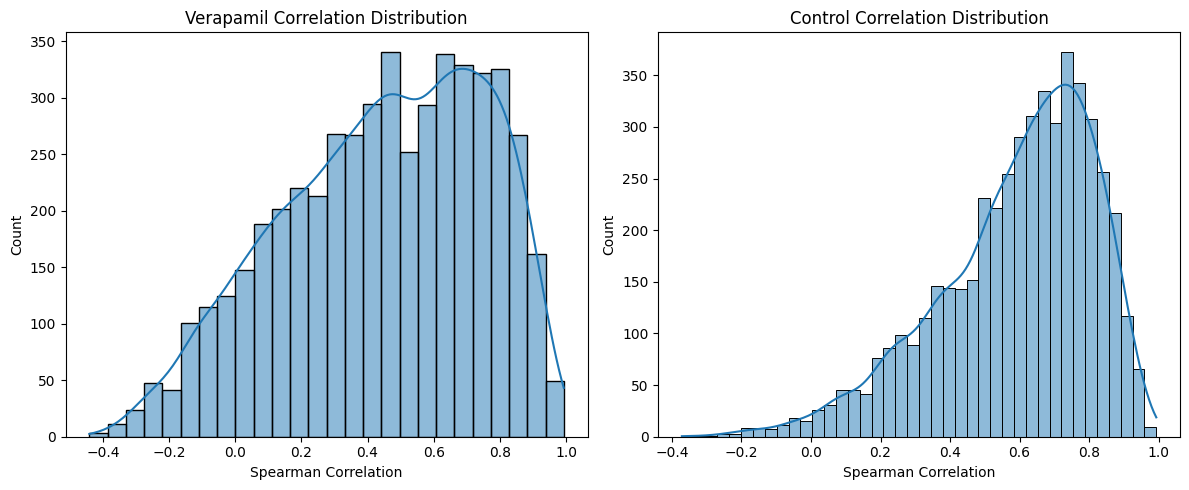

Automatically determined correlation threshold: 0.741


In [28]:
# -------------------------------------------------
# 3. CORRELATION DISTRIBUTION ANALYSIS
# -------------------------------------------------

# Examine correlation distribution to inform threshold selection
plt.figure(figsize=(12, 5))

# Plot treatment correlations
plt.subplot(1, 2, 1)
treatment_corr_values = treatment_corr.values[np.triu_indices_from(treatment_corr.values, k=1)]
sns.histplot(treatment_corr_values, kde=True)
plt.title("Verapamil Correlation Distribution")
plt.xlabel("Spearman Correlation")

# Plot control correlations
plt.subplot(1, 2, 2)
control_corr_values = control_corr.values[np.triu_indices_from(control_corr.values, k=1)]
sns.histplot(control_corr_values, kde=True)
plt.title("Control Correlation Distribution")
plt.xlabel("Spearman Correlation")

plt.tight_layout()
plt.savefig("correlation_distributions.png", dpi=300)
plt.show()

# Calculate correlation threshold based on distribution (e.g., 75th percentile)
# Alternatively, use a fixed threshold that makes biological sense
auto_threshold = np.percentile(np.abs(np.concatenate([treatment_corr_values, control_corr_values])), 75)
print(f"Automatically determined correlation threshold: {auto_threshold:.3f}")
#print(f"Using threshold of 0.7 for network construction (adjust if needed based on distribution)")
threshold = 0.741  # Adjust based on the correlation distribution if needed

In [29]:

# -------------------------------------------------
# 4. NETWORK CREATION
# -------------------------------------------------

# Function to create network from correlation matrix
def create_network(corr_matrix, threshold=0.7):
    """Create a network where edges represent correlations above threshold"""
    G = nx.Graph()
    # Add all genes as nodes first
    for gene in corr_matrix.index:
        G.add_node(gene)

    # Add edges for correlations above threshold
    for i, gene1 in enumerate(corr_matrix.index):
        for j, gene2 in enumerate(corr_matrix.columns):
            if i < j:  # Avoid duplicate pairs and self-loops
                correlation = corr_matrix.iloc[i, j]
                if abs(correlation) >= threshold:
                    G.add_edge(gene1, gene2, weight=abs(correlation))
    return G

# Create networks with correlation threshold
print("Building co-expression networks...")
treatment_network = create_network(treatment_corr, threshold)
control_network = create_network(control_corr, threshold)

# Print network statistics
print(f"Treatment network: {treatment_network.number_of_nodes()} nodes, {treatment_network.number_of_edges()} edges")
print(f"Control network: {control_network.number_of_nodes()} nodes, {control_network.number_of_edges()} edges")


Building co-expression networks...
Treatment network: 100 nodes, 1002 edges
Control network: 100 nodes, 1485 edges


In [30]:

# -------------------------------------------------
# 5. NETWORK METRICS CALCULATION
# -------------------------------------------------

print("\nCalculating network metrics...")

# Network density (fraction of possible edges that exist)
density_treatment = nx.density(treatment_network)
density_control = nx.density(control_network)
print(f"Density of Verapamil network: {density_treatment:.4f}")
print(f"Density of Control network: {density_control:.4f}")

# Average degree (average number of connections per gene)
avg_degree_treatment = sum(dict(treatment_network.degree()).values()) / len(treatment_network.nodes) if treatment_network.nodes else 0
avg_degree_control = sum(dict(control_network.degree()).values()) / len(control_network.nodes) if control_network.nodes else 0
print(f"Average degree in Verapamil network: {avg_degree_treatment:.2f}")
print(f"Average degree in Control network: {avg_degree_control:.2f}")

# Clustering coefficient (measure of node clustering)
if treatment_network.nodes:
    avg_clustering_treatment = nx.average_clustering(treatment_network)
    print(f"Average clustering coefficient in Verapamil network: {avg_clustering_treatment:.4f}")
else:
    print("Verapamil network has no nodes for clustering coefficient calculation")

if control_network.nodes:
    avg_clustering_control = nx.average_clustering(control_network)
    print(f"Average clustering coefficient in Control network: {avg_clustering_control:.4f}")
else:
    print("Control network has no nodes for clustering coefficient calculation")

# Save network metrics
metrics_df = pd.DataFrame({
    'Metric': ['Nodes', 'Edges', 'Density', 'Avg Degree', 'Clustering Coefficient'],
    'Verapamil': [
        treatment_network.number_of_nodes(),
        treatment_network.number_of_edges(),
        density_treatment,
        avg_degree_treatment,
        avg_clustering_treatment if treatment_network.nodes else 0
    ],
    'Control': [
        control_network.number_of_nodes(),
        control_network.number_of_edges(),
        density_control,
        avg_degree_control,
        avg_clustering_control if control_network.nodes else 0
    ]
})
metrics_df.to_csv("network_metrics.csv", index=False)



Calculating network metrics...
Density of Verapamil network: 0.2024
Density of Control network: 0.3000
Average degree in Verapamil network: 20.04
Average degree in Control network: 29.70
Average clustering coefficient in Verapamil network: 0.6164
Average clustering coefficient in Control network: 0.6152


In [31]:

# -------------------------------------------------
# 6. COMMUNITY/MODULE DETECTION
# -------------------------------------------------

print("\nDetecting network communities...")

try:
    from networkx.algorithms import community

    # Detect communities using Louvain method (if networks have edges)
    if treatment_network.number_of_edges() > 0:
        treatment_communities = community.louvain_communities(treatment_network)
        print(f"Verapamil network: {len(treatment_communities)} communities detected")

        # Calculate modularity
        treatment_modularity = community.modularity(treatment_network, treatment_communities)
        print(f"Modularity of Verapamil network: {treatment_modularity:.4f}")
    else:
        treatment_communities = []
        print("Verapamil network has no edges for community detection")

    if control_network.number_of_edges() > 0:
        control_communities = community.louvain_communities(control_network)
        print(f"Control network: {len(control_communities)} communities detected")

        # Calculate modularity
        control_modularity = community.modularity(control_network, control_communities)
        print(f"Modularity of Control network: {control_modularity:.4f}")
    else:
        control_communities = []
        print("Control network has no edges for community detection")

except ImportError:
    print("Note: Community detection algorithms not available. Using NetworkX version may be outdated.")
    treatment_communities = []
    control_communities = []




Detecting network communities...
Verapamil network: 8 communities detected
Modularity of Verapamil network: 0.4664
Control network: 9 communities detected
Modularity of Control network: 0.1939


In [32]:
# -------------------------------------------------
# 7. HUB GENE IDENTIFICATION
# -------------------------------------------------

print("\nIdentifying hub genes in networks...")

# Identify hub genes (genes with most connections)
treatment_degrees = dict(treatment_network.degree())
sorted_treatment_genes = sorted(treatment_degrees.items(), key=lambda x: x[1], reverse=True)

control_degrees = dict(control_network.degree())
sorted_control_genes = sorted(control_degrees.items(), key=lambda x: x[1], reverse=True)

# Display top hub genes
print("\nTop 10 hub genes in Verapamil network:")
for gene, degree in sorted_treatment_genes[:10]:
    print(f"{gene}: {degree} connections")

print("\nTop 10 hub genes in Control network:")
for gene, degree in sorted_control_genes[:10]:
    print(f"{gene}: {degree} connections")

# Save hub gene information
hub_genes_df = pd.DataFrame({
    'Treatment_Gene': [gene for gene, _ in sorted_treatment_genes[:20]] if sorted_treatment_genes else [None]*20,
    'Treatment_Connections': [degree for _, degree in sorted_treatment_genes[:20]] if sorted_treatment_genes else [0]*20,
    'Control_Gene': [gene for gene, _ in sorted_control_genes[:20]] if sorted_control_genes else [None]*20,
    'Control_Connections': [degree for _, degree in sorted_control_genes[:20]] if sorted_control_genes else [0]*20
})
hub_genes_df.to_csv("hub_genes.csv", index=False)
print("Hub genes information saved to hub_genes.csv")




Identifying hub genes in networks...

Top 10 hub genes in Verapamil network:
Atf4: 34 connections
Hmgcr: 34 connections
Hmgcs1: 33 connections
Tmem215: 33 connections
Slc38a3: 32 connections
Stc1: 32 connections
Chac1: 31 connections
Insig1: 31 connections
Mfsd2a: 31 connections
Psat1: 31 connections

Top 10 hub genes in Control network:
Sdf2l1: 66 connections
Dhcr7: 61 connections
Atf4: 58 connections
Acss2: 57 connections
Parvb: 57 connections
St8sia2: 57 connections
Hmgcr: 56 connections
Gabrq: 56 connections
Wnt4: 54 connections
Plk3: 54 connections
Hub genes information saved to hub_genes.csv


In [33]:
# -------------------------------------------------
# 8. HUB GENE COMPARISON
# -------------------------------------------------

# Define hub genes as the top 10 most connected nodes
hub_genes_treatment = set([gene for gene, degree in sorted_treatment_genes[:10]] if sorted_treatment_genes else [])
hub_genes_control = set([gene for gene, degree in sorted_control_genes[:10]] if sorted_control_genes else [])

# Find common and unique hub genes
common_hub_genes = hub_genes_treatment.intersection(hub_genes_control)
unique_treatment_hub_genes = hub_genes_treatment - hub_genes_control
unique_control_hub_genes = hub_genes_control - hub_genes_treatment

print("\nHub gene comparison:")
print(f"Common hub genes ({len(common_hub_genes)}): {common_hub_genes}")
print(f"Unique Verapamil hub genes ({len(unique_treatment_hub_genes)}): {unique_treatment_hub_genes}")
print(f"Unique Control hub genes ({len(unique_control_hub_genes)}): {unique_control_hub_genes}")

# Save hub gene comparison results
hub_comparison = {
    'Category': ['Common', 'Unique to Verapamil', 'Unique to Control'],
    'Genes': [
        ', '.join(common_hub_genes),
        ', '.join(unique_treatment_hub_genes),
        ', '.join(unique_control_hub_genes)
    ],
    'Count': [
        len(common_hub_genes),
        len(unique_treatment_hub_genes),
        len(unique_control_hub_genes)
    ]
}
hub_comparison_df = pd.DataFrame(hub_comparison)
hub_comparison_df.to_csv("hub_gene_comparison.csv", index=False)



Hub gene comparison:
Common hub genes (2): {'Atf4', 'Hmgcr'}
Unique Verapamil hub genes (8): {'Insig1', 'Hmgcs1', 'Tmem215', 'Slc38a3', 'Stc1', 'Psat1', 'Chac1', 'Mfsd2a'}
Unique Control hub genes (8): {'Dhcr7', 'St8sia2', 'Plk3', 'Gabrq', 'Wnt4', 'Acss2', 'Sdf2l1', 'Parvb'}



Generating network visualizations...


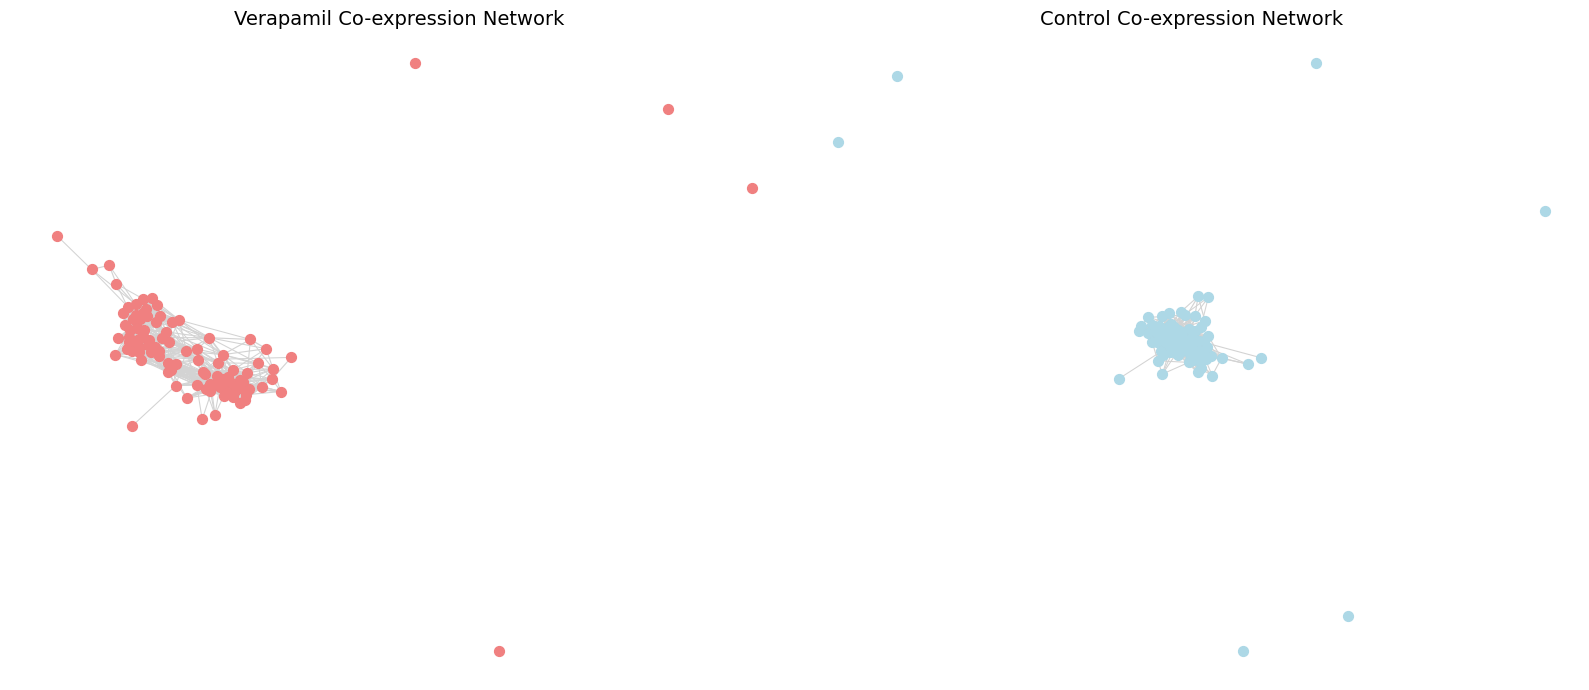

In [34]:

# -------------------------------------------------
# 9. VISUALIZATIONS
# -------------------------------------------------

# 9.1 Visualize full networks side by side
print("\nGenerating network visualizations...")
plt.figure(figsize=(16, 7))

# Set consistent layout for both networks using spring layout with fixed seed
pos_treatment = nx.spring_layout(treatment_network, seed=42)
pos_control = nx.spring_layout(control_network, seed=42)

# Treatment network
plt.subplot(1, 2, 1)
nx.draw(treatment_network, pos_treatment,
        node_color='lightcoral',
        node_size=50,
        edge_color='lightgray',
        width=[treatment_network[u][v]['weight'] for u, v in treatment_network.edges()] if treatment_network.edges else [],
        with_labels=False)
plt.title("Verapamil Co-expression Network", fontsize=14)

# Control network
plt.subplot(1, 2, 2)
nx.draw(control_network, pos_control,
        node_color='lightblue',
        node_size=50,
        edge_color='lightgray',
        width=[control_network[u][v]['weight'] for u, v in control_network.edges()] if control_network.edges else [],
        with_labels=False)
plt.title("Control Co-expression Network", fontsize=14)

plt.tight_layout()
plt.savefig("coexpression_networks.png", dpi=300)
plt.show()



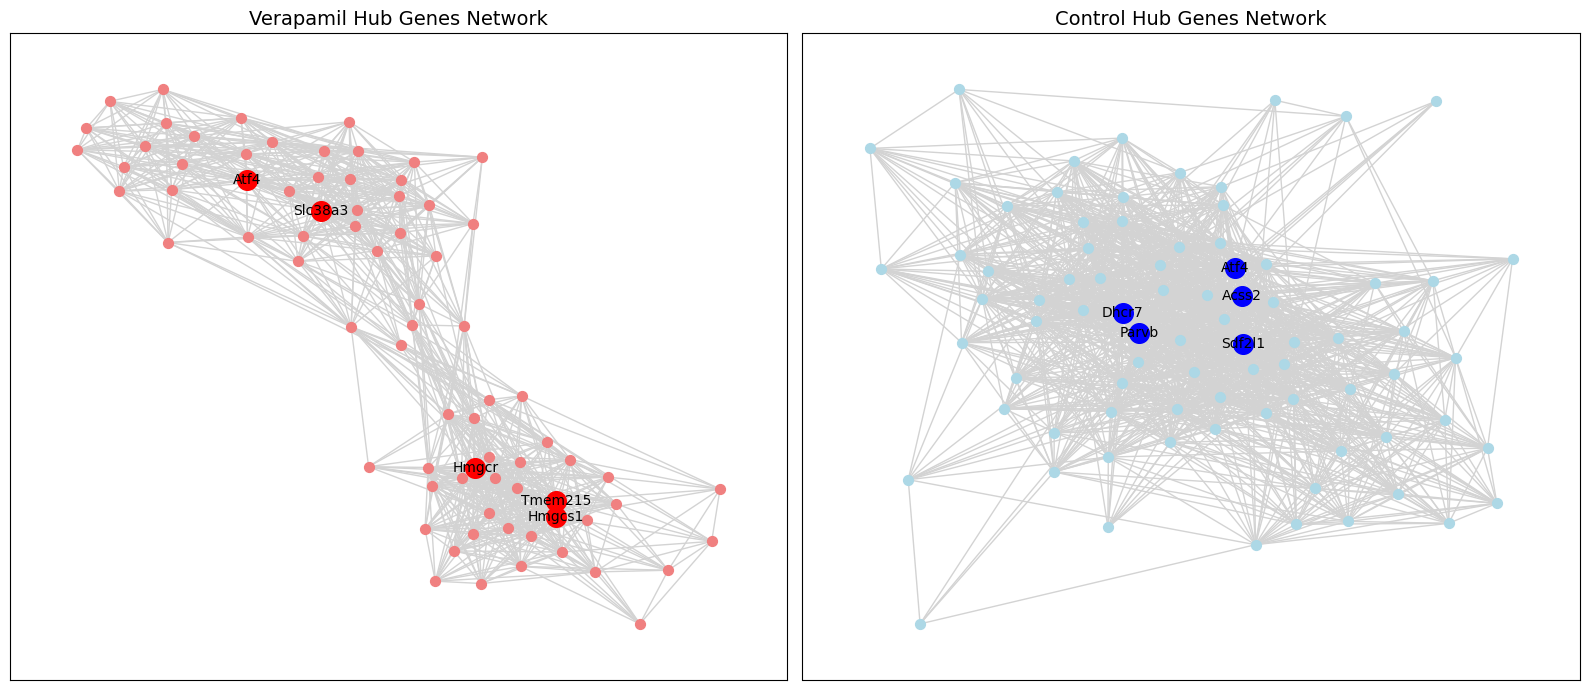

In [35]:
# 9.2 Visualize hub genes
# Function to extract subnetwork around hub genes
def get_hub_subnetwork(network, hub_genes, depth=1):
    """Extract subnetwork of hub genes and their neighbors up to specified depth"""
    if not hub_genes:
        return nx.Graph()

    subgraph = network.copy()
    nodes_to_keep = set(hub_genes)

    # Add neighbors up to specified depth
    current_nodes = set(hub_genes)
    for _ in range(depth):
        neighbors = set()
        for node in current_nodes:
            if node in subgraph:
                neighbors.update(subgraph.neighbors(node))
        current_nodes = neighbors
        nodes_to_keep.update(neighbors)

    # Keep only the nodes in the set
    nodes_to_remove = set(subgraph.nodes()) - nodes_to_keep
    for node in nodes_to_remove:
        subgraph.remove_node(node)

    return subgraph

# Extract top 5 hub genes
top_treatment_hubs = [gene for gene, _ in sorted_treatment_genes[:5]] if sorted_treatment_genes else []
top_control_hubs = [gene for gene, _ in sorted_control_genes[:5]] if sorted_control_genes else []

# Create subnetworks around hub genes
treatment_hub_network = get_hub_subnetwork(treatment_network, top_treatment_hubs)
control_hub_network = get_hub_subnetwork(control_network, top_control_hubs)

# Plot hub-centric networks
plt.figure(figsize=(16, 7))

# Treatment hub network
plt.subplot(1, 2, 1)
if treatment_hub_network.nodes:
    pos_t_hub = nx.spring_layout(treatment_hub_network, seed=42)
    # Draw regular nodes
    nx.draw_networkx_nodes(treatment_hub_network, pos_t_hub,
                        nodelist=[n for n in treatment_hub_network.nodes() if n not in top_treatment_hubs],
                        node_color='lightcoral', node_size=50)
    # Draw hub nodes with larger size
    nx.draw_networkx_nodes(treatment_hub_network, pos_t_hub,
                        nodelist=top_treatment_hubs,
                        node_color='red', node_size=200)
    # Draw edges
    nx.draw_networkx_edges(treatment_hub_network, pos_t_hub, edge_color='lightgray')
    # Draw labels only for hub genes
    nx.draw_networkx_labels(treatment_hub_network, pos_t_hub,
                        {n: n for n in top_treatment_hubs},
                        font_size=10)
plt.title("Verapamil Hub Genes Network", fontsize=14)

# Control hub network
plt.subplot(1, 2, 2)
if control_hub_network.nodes:
    pos_c_hub = nx.spring_layout(control_hub_network, seed=42)
    # Draw regular nodes
    nx.draw_networkx_nodes(control_hub_network, pos_c_hub,
                        nodelist=[n for n in control_hub_network.nodes() if n not in top_control_hubs],
                        node_color='lightblue', node_size=50)
    # Draw hub nodes with larger size
    nx.draw_networkx_nodes(control_hub_network, pos_c_hub,
                        nodelist=top_control_hubs,
                        node_color='blue', node_size=200)
    # Draw edges
    nx.draw_networkx_edges(control_hub_network, pos_c_hub, edge_color='lightgray')
    # Draw labels only for hub genes
    nx.draw_networkx_labels(control_hub_network, pos_c_hub,
                        {n: n for n in top_control_hubs},
                        font_size=10)
plt.title("Control Hub Genes Network", fontsize=14)

plt.tight_layout()
plt.savefig("hub_gene_networks.png", dpi=300)
plt.show()



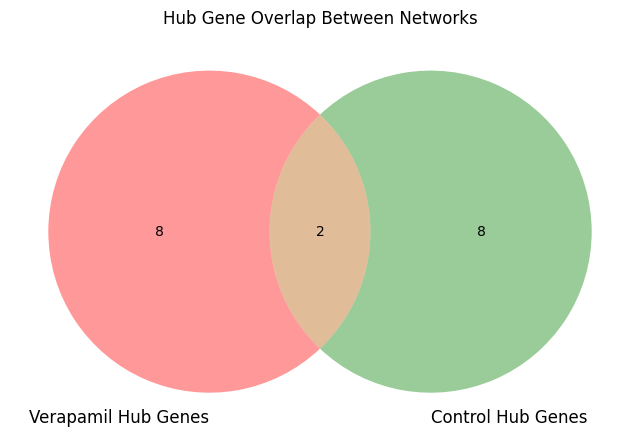

In [36]:
# 9.3 Visualize hub gene overlap with Venn diagram
try:
    from matplotlib_venn import venn2

    plt.figure(figsize=(8, 6))
    if hub_genes_treatment or hub_genes_control:
        venn2([hub_genes_treatment, hub_genes_control],
            set_labels=('Verapamil Hub Genes', 'Control Hub Genes'))
        plt.title('Hub Gene Overlap Between Networks')
        plt.savefig("hub_gene_venn.png", dpi=300)
        plt.show()
except ImportError:
    print("Note: matplotlib-venn package not available for Venn diagram. To install, use: pip install matplotlib-venn")

    # Alternative visualization if matplotlib-venn is not available
    plt.figure(figsize=(8, 6))
    plt.bar(['Common', 'Unique to Verapamil', 'Unique to Control'],
            [len(common_hub_genes), len(unique_treatment_hub_genes), len(unique_control_hub_genes)],
            color=['purple', 'lightcoral', 'lightblue'])
    plt.title('Hub Gene Distribution')
    plt.ylabel('Number of genes')
    plt.savefig("hub_gene_distribution.png", dpi=300)
    plt.show()



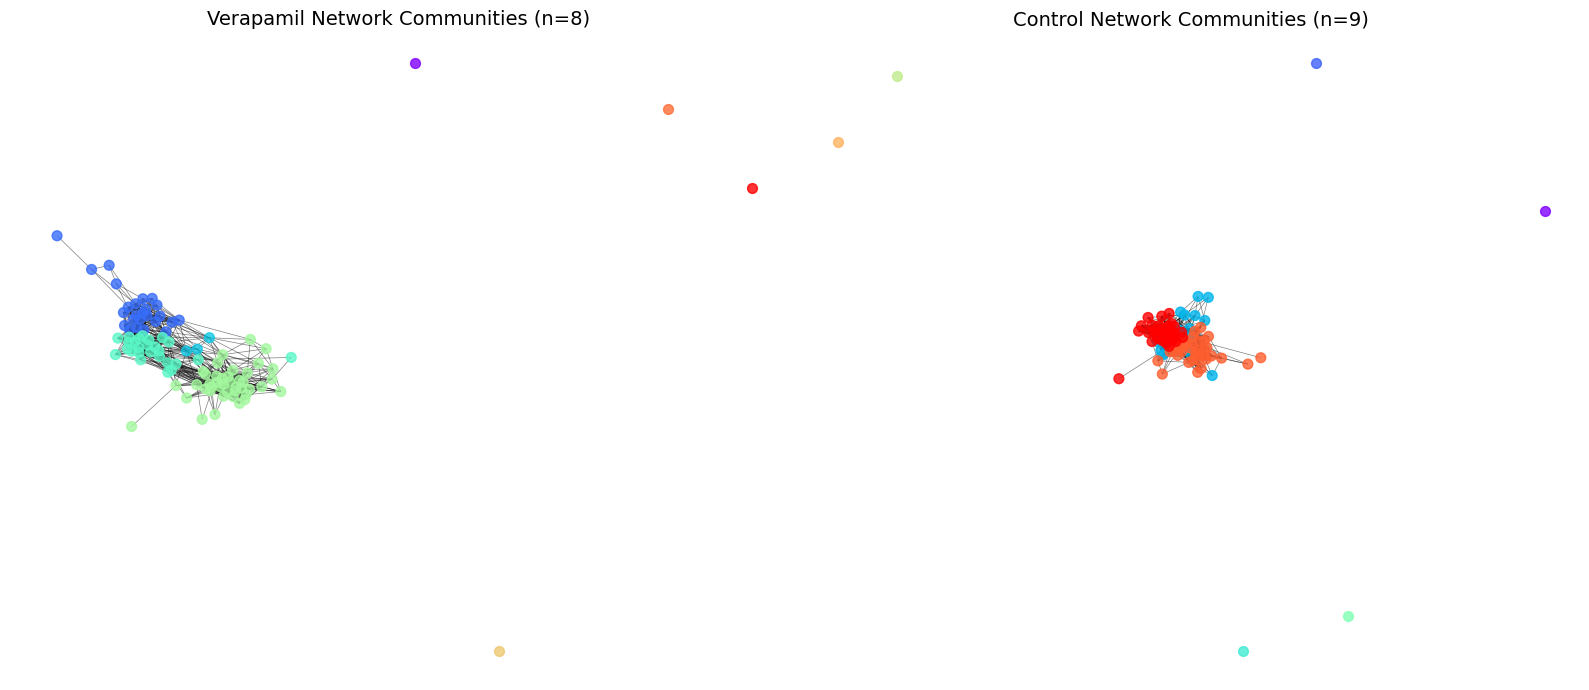


WGCNA-style co-expression analysis completed!


In [37]:
# 9.4 Visualize communities if detected
if treatment_communities or control_communities:
    try:
        plt.figure(figsize=(16, 7))

        # Function to visualize communities
        def plot_communities(network, communities, pos, ax, title):
            if not communities:
                ax.text(0.5, 0.5, "No communities detected",
                        ha='center', va='center', fontsize=12)
                ax.axis('off')
                return

            # Generate colors for communities
            colors = plt.cm.rainbow(np.linspace(0, 1, len(communities)))

            # Draw nodes with community colors
            for i, comm in enumerate(communities):
                nx.draw_networkx_nodes(network, pos,
                                    nodelist=list(comm),
                                    node_color=[colors[i]] * len(comm),
                                    node_size=50,
                                    alpha=0.8,
                                    ax=ax)

            # Draw edges
            nx.draw_networkx_edges(network, pos, width=0.5, alpha=0.5, ax=ax)
            ax.set_title(title, fontsize=14)
            ax.axis('off')

        # Plot treatment communities
        ax1 = plt.subplot(1, 2, 1)
        plot_communities(treatment_network, treatment_communities, pos_treatment, ax1,
                        f"Verapamil Network Communities (n={len(treatment_communities)})")

        # Plot control communities
        ax2 = plt.subplot(1, 2, 2)
        plot_communities(control_network, control_communities, pos_control, ax2,
                        f"Control Network Communities (n={len(control_communities)})")

        plt.tight_layout()
        plt.savefig("network_communities.png", dpi=300)
        plt.show()

    except Exception as e:
        print(f"Error visualizing communities: {e}")

print("\nWGCNA-style co-expression analysis completed!")